# Solve the eigenvalue equation $\mathbf{\mathcal{A}q}=\omega \mathbf{\mathcal{B}q}$  and $\mathbf{\mathcal{A}q} = \alpha \mathbf{\mathcal{B}q}$ for the Orr-Sommerfeld and Squire equations.

This notebook contains information on how we solve the Orr-Sommerfeld and squire equations using both the formulation in Schmid textbook and the primitive variable formulation.

## import libraries and plotting style

In [1]:
# import libraries and set plotting style.  
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy import linalg,sparse
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.patches as patches

In [2]:
# set ipython display and matplotlib notebook
from IPython.display import set_matplotlib_formats
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
set_matplotlib_formats('png', 'pdf')
#%matplotlib inline
%matplotlib notebook
plt.style.use('seaborn-notebook')



## Declare functions for Base flow (plane flow between parallel plates) and derivative operators
Also declare plotting functions

In [3]:
# Declare functions for base flow and finite difference derivative operators
def base_flow(y,output_full=False,Dim=2):
    '''
    Input:
        y: array of height of channel
        Dim: dimension of desired output
    Output base flow for plane Poiseuille flow between two parallel plates
        U: U mean velocity (vector)
        Uy: dU/dy of mean belocity (vector)
        Uyy: d^2 U/dy^2 of mean velocity (scalar)
    '''
    if Dim==2:
        _y = y[:,np.newaxis]
    elif Dim==3:
        _y = y[:,np.newaxis,np.newaxis]
    if output_full:
        U = 1.-_y**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
        Uy = -2.*_y # dU/dy of base flow
        Uyy = -2. # d^2 U/dy^2 of base flow
    else:
        U = 1.-_y[1:-1]**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
        Uy = -2.*_y[1:-1] # dU/dy of base flow
        Uyy = -2. # d^2 U/dy^2 of base flow
    return U,Uy,Uyy
def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D(y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False):
    '''
    Input:
        y: array of y values of channel
        order: order of accuracy desired (assuming even e.g. 2,4,6,...)
        d: dth derivative
    Output:
        D: (n-2 by n) dth derivative of order O(h^order) assuming uniform y spacing
    '''
    h = y[1]-y[0] # uniform spacing
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    # get coefficients for main diagonals
    N=order+d # how many pts needed for order of accuracy
    if N>n:
        raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
    Nm1=N-1 # how many pts needed if using central difference is equal to N-1
    if (d % 2 != 0): # if odd derivative
        Nm1+=1 # add one more point to central, to count the i=0 0 coefficient
    # stencil and get Coeffs for diagonals
    s = np.arange(Nm1)-int((Nm1-1)/2) # stencil for central diff of order
    smax=s[-1] # right most stencil used (positive range)
    Coeffs = get_D_Coeffs(s,d=d)
    # loop over s and add coefficient matrices to D
    D = np.zeros_like(I)
    si = np.nditer(s,('c_index',))
    while not si.finished:
        i = si.index
        if si[0]==0:
            diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
        else:
            diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])

        D += diag_to_add
        if periodic:
            if si[0]>0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]-n)
            elif si[0]<0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]+n)
            if si[0]!=0:
                D += diag_to_add
                
        si.iternext()
    if not periodic:
        # alter BC so we don't go out of range on bottom of channel
        for i in range(0,smax):
            # for ith row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = np.arange(Nm1-1)-i # stencil for shifted diff of order-1
                else:
                    s = np.arange(Nm1)-i # stencil for shifted diff of order-1
            else:
                s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[i,:] = 0. # set row to zero
            D[i,s+i] = Coeffs # set row to have proper coefficients

            # for -ith-1 row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = -(np.arange(Nm1-1)-i) # stencil for shifted diff of order-1
                else:
                    s = -(np.arange(Nm1)-i) # stencil for shifted diff of order-1
            else:
                s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[-i-1,:] = 0. # set row to zero
            D[-i-1,s-i-1] = Coeffs # set row to have proper coefficients

    if output_full:
        return (1./(h**d)) * D # do return the full matrix
    else:
        return (1./(h**d)) * D[1:-1,:] # do not return the top or bottom row
def set_D_for_zi(y,z,zi,output_full=False,**kwargs):
    '''
    set a 3D matrix of derivative operators for  Dy and Dz of the proper order
    
    Inputs:
        y: y spatial array
        z: z spatial array
        zi: z index currently
        order: order of accuracy desired in derivatives
        **kwargs: other keyword arguments for set_D function
    Returns:
        Dy: (3D matrix of all y values, at particular zi index)
        Dz: (3D matrix of all y values, at particular zi index)
    '''
    ny=y.size
    nz=z.size
    # calc derivatives for y
    Dy = set_D(y,output_full=output_full,**kwargs) 
    # set zero matrix
    zero = np.zeros(Dy.shape+(nz,))
    Dy_all = np.copy(zero)
    Dz_all = np.copy(zero)
    # set derivatives for y
    #hy=y[1]-y[0]
    Dy_all[:,:,zi] = Dy
    # calculate derivatives for z
    #hz=z[1]-z[0]
    Dz = set_D(z,periodic=True,output_full=True,**kwargs)[zi]
    # set derivatives into bigger matrix to be returned
    for i in range(ny-2):
        Dz_all[i,i+1,:] = Dz
    return Dy_all,Dz_all
#y=np.linspace(-1,1,6)
#h=y[1]-y[0]
#D = set_D(y,d=1,order=4,output_full=True,periodic=True)*h**2
#display(pd.DataFrame(D))

In [4]:
# functions for plotting eigenfunctions on branches
def add_evec_y_branch(ax,n,y,eig_Ai,eig,evec,branch_title,eig_type=r'\omega'):
    ax.set_title(branch_title + r' $'+eig_type+' = %.1e+%.1ej$'%(eig[eig_Ai].real,eig[eig_Ai].imag))
    ax.plot( np.abs(evec[:,eig_Ai]),
        y,
        label=r'abs')
    ax.plot( evec[:,eig_Ai].real,
        y,
        label=r'real')
    ax.plot( evec[:,eig_Ai].imag,
        y,
        label=r'imag')
def plot_evec_a_branch(y,n,Ai,eig,evec,title='',eig_type=r'\omega'):
    # get indices of branches
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    # open figure and plot the three branches
    fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(3,3))
    add_evec_y_branch(ax,n,y,eig_A_i,eig,evec,'A',eig_type=eig_type)
    ax.legend(loc='best',frameon=False,numpoints=1)
    ax.set_xlabel(title)
    ax.set_ylabel(r'$y$')
    fig.tight_layout()
    plt.show()
def plot_evec_all_branches(y,n,Ai,Pi,Si,eig,evec,title=''):
    # get indices of branches
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    eig_P_i = np.nanargmin((np.abs(eig-Pi)))
    eig_S_i = np.nanargmin((np.abs(eig-Si)))
    # open figure and plot the three branches
    fig,ax=plt.subplots(nrows=3,ncols=1,sharey=True,figsize=(3,7))
    add_evec_y_branch(ax[0],n,y,eig_A_i,eig,evec,'A')
    add_evec_y_branch(ax[1],n,y,eig_P_i,eig,evec,'P')
    add_evec_y_branch(ax[2],n,y,eig_S_i,eig,evec,'S')
    ax[0].legend(loc='best',frameon=False,numpoints=1)
    #ax[1].legend(loc='best',frameon=False,numpoints=1)
    #ax[2].legend(loc='best',frameon=False,numpoints=1)
    ax[2].set_xlabel(title)
    [axi.set_ylabel(r'$y$') for axi in ax]
    fig.tight_layout()
    plt.show()

In [5]:
# functions for calc and plotting mesh convergence
def RSSE_n(solver,c,order=2,iplot=False,n_all=[51,61,71,81,91,101,151],z=False,**kwargs):
    RSSE_n=[]
    for n in n_all:
        # solve eigenvalue problem
        if z==False:
            #y=np.linspace(-1,1,n)
            eig,evec,eig_i = solver(   
                n=n,
                order=order,
                iplot=iplot,
                **kwargs)
        elif z:
            #y=np.linspace(-1,1,n[0])
            #z=np.linspace(-1,1,n[1])
            eig,evec,eig_i = solver(   
                ny=n[0],
                nz=n[1],
                order=order,
                iplot=iplot,
                **kwargs)
            
        eig_ci=[]
        for ci in c:
            eig_ci.append(np.nanargmin(np.abs(eig-ci)))
            

        # plot against table
        if iplot:
            fig=plt.figure() 
            ax=plt.subplot(111)
            ax.plot(c.real,c.imag,'s',label='c Schmid')
            ax.plot(eig[eig_ci].real,eig[eig_ci].imag,'.',label='Finit Difference')
            ax.set_xlabel(r'$\omega_r$')
            ax.set_ylabel(r'$\omega_i$')
            ax.legend(loc='best',numpoints=1)
            fig.tight_layout()
            plt.show()

        # calc error as root sum squared
        RSSE= np.sqrt(np.sum(np.abs(eig[eig_ci] - c)**2))
        RSSE_n.append(RSSE)
        if z==False:
            print('for n = %i, order = %i, then RSSE = %.3e'%(n,order,RSSE))
        elif z:
            print('for ny = %i, nz = %i, order = %i, then RSSE = %.3e'%(n[0],n[1],order,RSSE))
    return (eig,eig_ci,n_all,RSSE_n)
def calc_and_plot_eigs_RSSE(solver,c,axdiff=None,axcon=None,
                            color='b',order=2,n_all=[101,161],z=False,**kwargs):
    # calc eigenvalues of order
    eig,eig_ci,n_all,RSSE_n2 = RSSE_n(solver,c,order=order,n_all=n_all,z=z,**kwargs)
    # plot eigenvalues
    axdiff.plot(eig[eig_ci].real,eig[eig_ci].imag
                ,'.',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    # plot error convergence
    if z==False:
        axcon.loglog(n_all,RSSE_n2
                     ,'o',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    elif z:
        axcon.loglog([n_all[i][0] for i,val in enumerate(n_all)],RSSE_n2
                     ,'o',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    # return the highest error term, to be used to plotting convergence expectation
    return RSSE_n2[0] 
    
def add_legend_outside(fig,ax, x0=1,y0=1, direction = "h", padpoints = 3,**kwargs):
    otrans = ax.figure.transFigure
    t = ax.legend(bbox_to_anchor=(x0,y0), loc=1, bbox_transform=otrans,**kwargs)
    plt.tight_layout()
    ax.figure.canvas.draw()
    plt.tight_layout()
    ppar = [0,-padpoints/72.] if direction == "v" else [-padpoints/72.,0] 
    trans2=matplotlib.transforms.ScaledTranslation(ppar[0],ppar[1],fig.dpi_scale_trans)+\
             ax.figure.transFigure.inverted() 
    tbox = t.get_window_extent().transformed(trans2 )
    bbox = ax.get_position()
    if direction=="v":
        ax.set_position([bbox.x0, bbox.y0,bbox.width, tbox.y0-bbox.y0]) 
    else:
        ax.set_position([bbox.x0, bbox.y0,tbox.x0-bbox.x0, bbox.height])
    
def plot_mesh_convergence(solver,c,orders=[2,4,],n_all=[101,161],z=False,**kwargs):
    
    fig1=plt.figure(figsize=(6,4))  # plot for finite diffs
    axdiff=plt.subplot(111)
    axdiff.plot(c.real,c.imag,'s',label='Schmid')
    axdiff.set_xlabel(r'$\omega_r$')
    axdiff.set_ylabel(r'$\omega_i$')

    fig2=plt.figure(figsize=(6,4)) 
    axcon=plt.subplot(111)
    axcon.set_xlabel(r'$n$')
    axcon.set_ylabel(r'$RSSE$')
    axcon.set_prop_cycle(None)

    #n_all = [81,91,101,111,121,162]
    for orderi in orders:
        colori = next(axcon._get_lines.prop_cycler)
        RSSE_n2 = calc_and_plot_eigs_RSSE(solver,c,axdiff=axdiff,axcon=axcon
                                          ,color=colori['color'],order=orderi,n_all=n_all,z=z,**kwargs)
        if z==False:
            axcon.loglog([n_all[0],n_all[0]*2],[RSSE_n2,RSSE_n2/2**orderi],
                         color=colori['color'],label=r'$O(h^{%i})$ line'%orderi)
        elif z:
            axcon.loglog([n_all[0][0],n_all[0][0]*2],[RSSE_n2,RSSE_n2/2**orderi],
                         color=colori['color'],label=r'$O(h^{%i})$ line'%orderi)
    add_legend_outside(fig1,axdiff)
    add_legend_outside(fig2,axcon)
    plt.show()

## Solve using Orr-Sommerfeld Squire formulation of $\hat{v}$ and $\hat{\eta}$
The Orr-Sommerfeld and Squire equations in the wavelike results can be derived following Schmid's textbook in chapter 3 of "Stability and Transition in Shear Flows"
The equations shown here are equations (3.14) and (3.15)
$$\left[ (-i \omega+i \alpha U)(\mathcal{D}^2 - k^2) - i \alpha U'' - \frac{1}{Re} (\mathcal{D}^2 - k^2)^2 \right] \hat{v} = 0$$
$$\left[ (-i \omega+i \alpha U) - \frac{1}{Re}(\mathcal{D}^2 - k^2) \right] \hat{\eta} = -i \beta U' \hat{v}$$
And rearranging these equations to be of the form
$$A\hat{q} = \omega B\hat{q}$$
where $\hat{q} = [\hat{v}, \hat{\eta}]^\intercal$
Then the equations take the form shown here.
$$[
    (\underbrace{i \alpha Re U (-k^2) - i \alpha Re U_{yy} - k^4}_{a_A}) 
    + (\underbrace{i \alpha Re U + 2k^2}_{b_A}) \mathcal{D}^2 
    - \mathcal{D}^4 
] \hat{v} = \omega (
    \underbrace{-i Re k^2}_{a_B} 
    + \underbrace{i Re}_{b_B} \mathcal{D}^2
) \hat{v}$$
$$A_{os}\hat{v} = \omega B_{os} \hat{v}$$
Which can be solved alone for $\hat{v}$ given the boundary conditions at the walls to be $v=v'=0$

This can then be coupled with the $\hat{\eta}$ equation shown here to get the $\hat{\eta}$ modes as well.
$$[ (\underbrace{i \alpha Re U + k^2}_{c_A})
        +(\underbrace{-1}_{d_A})\mathcal{D}^2 ] \hat{\eta}
    + [
        \underbrace{i \beta Re U_y}_{f_A} ] \hat{v}
    = \omega [(\underbrace{i Re}_{c_B})] \hat{\eta}$$
$$A_{sq \eta}\hat{\eta} + A_{sq v}\hat{v} = \omega B_{sq \eta} \hat{\eta}$$
So to combine these equations to
$$A\hat{q} = \omega B\hat{q}$$
requires 
$$A = 
\begin{bmatrix}
A_{os} & 0 \\
A_{sq v} & A_{sq \eta}
\end{bmatrix}$$
and 
$$B = 
\begin{bmatrix}
B_{os} & 0 \\
B_{sq v} & B_{sq \eta}
\end{bmatrix}$$

        

In [ ]:
# functions for v and eta
def set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,order=2,large_multiple=2.):
    '''
    Set boundary condition values to Aos, Bos, Asq_v, Bsq_v, Asq_eta, and Bsq_eta
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    '''
    h=y[1]-y[0]
    #large_multiple=0.
    # v'=0 at walls
    # alter first and last line of Aos and Bos to contain v'=0 BC
    d=1 # derivative
    N=order+d # how many pts needed for order of accuracy
    s = np.arange(N) # stencil for shifted diff of order for i=0
    sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
    Coeffs = get_D_Coeffs(s,d=d)
    Coeffsn = get_D_Coeffs(sn,d=d)
    Aos[(0,-1),:] = 0.
    Bos[(0,-1),:] = 0.
    Aos[0,s] = Coeffs
    Bos[0,s] = large_multiple*Coeffs
    Aos[-1,sn-1] = Coeffsn
    Bos[-1,sn-1] = large_multiple*Coeffsn
    # v=0 at walls
    # rows to add to Aos and Bos at top and bottom
    zero_row = np.zeros((1,Aos[0,:].size))
    v0_at_bottom = np.copy(zero_row)
    v0_at_bottom[0,0] = 1.
    v0_at_top = np.copy(zero_row)
    v0_at_top[0,-1] = 1.
    # add them to Aos and Bos
    Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
    Bos = np.concatenate((large_multiple*v0_at_bottom,Bos,large_multiple*v0_at_top),axis=0)
    # eta=0 at walls
    # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
    Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
    Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
    eta_at_bottom = v0_at_bottom
    eta_at_top = v0_at_top
    Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
    Bsq_eta = np.concatenate((large_multiple*eta_at_bottom,Bsq_eta,large_multiple*eta_at_top),axis=0)
    return (Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta)
def set_A_and_B(y,alpha=1,beta=0.,Re=2000.,compute='OSS',order=2,large_multiple=2.):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        alpha=1 : alpha value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        compute: which equations to compute Orr-Sommerfeld-Squire "OSS" or "OS" or "SQ"
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    k2=alpha**2 + beta**2
    ialpha=1.j * alpha
    
    # identity matrix
    I = np.eye(y.size)
    # base flow
    U,Uy,Uyy = base_flow(y)
    
    # calculate derivatives
    D2 = set_D(y,order=order,d=2)
    D4 = set_D(y,order=order,d=4)
    
    # for Orr-Sommerfeld eq. of the form
    # (aA + bA*D2 - D4)*v = w*(aB+bB*D2)*v  OS
    # set aA and bA constants for each y
    aA = (ialpha*Re*(U*(-k2)-Uyy)-k2**2)
    bA = (ialpha*Re*U+2.*k2)
    # set aB and bB constants for each y
    aB = -1.j*Re*k2
    bB = 1.j*Re
    # create Aos, Bos
    Aos = -D4 + bA*D2 + aA*I[1:-1,:]
    Bos =       bB*D2 + aB*I[1:-1,:]
    
    # for Squire eq. of the form
    # (cA+dA*D2)*eta + fA*v = w*cB*eta
    # set cA,dA, and fA constants for each y
    cA = (ialpha*Re*U + k2 )
    dA = (-1.              )
    fA = (1.j*beta*Re*Uy   )
    # set cB constant for each y
    cB = (1.j*Re           )
    # create eta Asq,Bsq 
    Asq_eta = dA*D2 + cA*I[1:-1,:]
    Bsq_eta =         cB*I[1:-1,:]
    # create v Asq,Bsq
    Asq_v = fA*I[1:-1,:] # cut top and bottom of I
    Bsq_v = 0.*I[1:-1,:]
    
    # BCs
    Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta = set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    if compute=='OSS':
        A = np.concatenate((
                np.concatenate((Aos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Asq_v,Asq_eta),axis=1)) # Squire
            ,axis=0)
        B = np.concatenate((
                np.concatenate((Bos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Bsq_v,Bsq_eta),axis=1)) # Squire
            ,axis=0)
    # if just Orr-Sommerfeld
    elif compute=='OS':
        A = Aos
        B = Bos
    elif compute=='SQ':
        A = Asq_eta
        B = Bsq_eta
    else :
        raise ValueError('compute needs to be OSS or OS instead of : %s'%compute)
        return 0
    
    return (A,B)
def set_and_solve_eig(n=201,compute='OSS',iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        compute: which equations to compute Orr-Sommerfeld-Squire "OSS" or "OS" or "SQ"
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    n=%i compute=%s order=%i'%(n,compute,order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,n)
    # solve eigenvalue problem
    A,B = set_A_and_B(y,compute=compute,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print('check max and min eig')
        print('   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print('   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print('check isnan and isinf')
        print('   ',eig[np.isnan(eig)])
        print('   ',eig[np.isinf(eig)])

        # check BCs
        print('check BCs v=v_y=eta=0')
        # check values at walls
        BadBCvn1 = evec[0,:]!=0
        BadBCvp1 = evec[n-1,:]!=0
        if compute=='OSS':
            BadBCetan1 = evec[n,:]!=0
            BadBCetap1 = evec[-1,:]!=0

        print('  bad boundary condition eigenfunctions satisfying v=0')
        print('   ',evec[0,BadBCvn1],
              'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0')
        print('   ',evec[n-1,BadBCvp1],
              'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0')
        if compute=='OSS':
            print('  bad boundary condition eigenfunctions satisfying eta=0')
            BadBCetan1 = evec[n,:]!=0
            BadBCetap1 = evec[-1,:]!=0
            print('   ',evec[n,BadBCetan1],
                  'with associated eig-value of',eig[BadBCetan1],' eta(y=-1)=0')
            print('   ',evec[-1,BadBCetap1],
                  'with associated eig-value of',eig[BadBCetap1],' eta(y=1 )=0')
        # now check v' using forward and backward 1st diff 2nd order
        d=1 # derivative
        N=order+d # how many pts needed for order of accuracy
        s = np.arange(N) # stencil for shifted diff of order for i=0
        sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
        Coeffs = get_D_Coeffs(s,d=d)
        Coeffsn = get_D_Coeffs(sn,d=d)
        #vy_bot = -3.*evec[0,:] + 4.*evec[1,:] - evec[2,:]
        vy_bot = (Coeffs[:,np.newaxis]*evec[0:N]).sum(axis=0)
        # now v'=0 at other wall
        #vy_top = 1.*evec[n-3,:] -4.*evec[n-2,:] + 3.*evec[n-1,:]
        vy_top = (Coeffsn[:,np.newaxis]*evec[n-1:n-1-N:-1]).sum(axis=0)
        # plot derivative at walls for every eigenfunction for v=0
        fig=plt.figure(figsize=(5,4))
        plt.title('dv/dy=0 at wall check')
        plt.plot(vy_bot[eig_i],'o',label='bot')
        plt.plot(vy_top[eig_i],'.',label='top')
        plt.ylabel(r'$\frac{d\hat{v}}{dy}(y=\pm 1)$')
        plt.xlabel(r'$\omega_{max}$ to $\omega_{min}$')
        plt.legend(loc='best',numpoints=1,frameon=False)
        fig.tight_layout()

    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        fig=plt.figure(figsize=(4,4))
        ax=plt.subplot(111)
        ax.plot(eig.real,eig.imag,'b.')
        ax.set_xlabel(r'$\omega_r$')
        ax.set_ylabel(r'$\omega_i$')
        ax.axis([0,1,-1.,0])
        ax.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i

### Solve and reproduce Schmid textbook results using this formulation 
(note the difference is that here we use a finite difference formulation)

In [ ]:
# for figure 3.1a
eig,evec,eig_i = set_and_solve_eig(
    n=201,
    alpha=1.,
    beta=0.,
    Re=10000.,
    compute='OSS',
    order=4,
    large_multiple=1e7,)

In [ ]:
# for Figure 3.2b
eig,evec,eig_i = set_and_solve_eig(
    n=275, 
    alpha=0.,
    beta=1.,
    Re=10000.,
    compute='OSS',
    order=4,
    large_multiple=1.e3)

In [ ]:
# compute for figure 3.2
n=151
y=np.linspace(-1,1,n)
compute='OSS'
eig,evec,eig_i = set_and_solve_eig(
    n=n,
    alpha=1.,
    beta=1.,
    Re=5000.,
    compute=compute,
    order=2,
    large_multiple=1.e1)

### plot A, P, and S branches

In [ ]:
# Ai, Pi, Si values to plot at
Ai = 0.31210030-0.01979866j
Pi = 0.95256584-0.04793417j
Si = (0.675-0.4190j)

In [ ]:
# plot A,P, and S branches for figure 3.2
#Ai = (0.3256-0.023j)
#Pi = (0.95006-0.049325j)
def add_v_y_branch(ax,n,y,eig_A_i,evec):
    ax.plot( np.abs(evec[:n,eig_A_i]),
        y,
        label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
    ax.plot( evec[:n,eig_A_i].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
    ax.plot( evec[:n,eig_A_i].imag,
        y,
        label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
def add_eta_y_branch(ax,n,y,eig_A_i,evec):
    ax.plot(np.abs(evec[n:,eig_A_i]),
        y,
        label=r'abs of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
    ax.plot(  evec[n:,eig_A_i].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
    ax.plot(  evec[n:,eig_A_i].imag,
        y,
        label=r'imag of $\omega = %.1e+%.1ej$'%(eig[eig_A_i].real,eig[eig_A_i].imag))
def plot_v_eta_y_branch(n,y,eig_A_i,evec,branch_title,compute='OSS'):
    fig=plt.figure(figsize=(14,4))
    if compute=='OSS':
        ax=plt.subplot(121)
        ax2=plt.subplot(122)
    elif compute=='OS':
        ax=plt.subplot(111)
    ax.set_title(branch_title)
    add_v_y_branch(ax,n,y,eig_A_i,evec)
    if compute=='OSS':
        add_eta_y_branch(ax2,n,y,eig_A_i,evec)
        ax2.set_xlabel(r'$\hat{\eta}$')
        ax2.set_ylabel(r'$y$')
        ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
    ax.set_xlabel(r'$\hat{v}$')
    ax.set_ylabel(r'$y$')
    fig.tight_layout()
    plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)

    
def Plot_APS(n,y,compute,Ai,Pi,Si,eig,evec):
    '''
    Plot the A, P, and S eigenvectors (three given complex points)
    Output, plots similar to those in Schmid
    '''
    eig_A_i = (np.abs(eig-Ai)).argmin()
    eig_P_i = (np.abs(eig-Pi)).argmin()
    eig_S_i = (np.abs(eig-Si)).argmin()

    #eig_S_i = (np.abs(eig-(0.6735-0.458))).argmin()
    # A,P, and S branches
    plot_v_eta_y_branch(n,y,eig_A_i,evec,'A branch',compute=compute)
    plot_v_eta_y_branch(n,y,eig_P_i,evec,'P branch',compute=compute)
    plot_v_eta_y_branch(n,y,eig_S_i,evec,'S branch',compute=compute)

    plt.show()
Plot_APS(n,y,compute,Ai,Pi,Si,eig,evec)

### Compare in Plane Poiseuille to Schmid table for $\alpha=1, \beta=0, Re=2000$

In [ ]:
# mesh convergence
cos=np.array([
    #0.31210030-0.01979866j,
    #0.42418427-0.07671992j,
    #0.92078667-0.07804706j,
    #0.92091806-0.07820060j,
    #0.85717055-0.13990151j,
    #0.85758968-0.14031674j,
    #0.79399812-0.20190508j,
    #0.79413424-0.20232063j,
    #0.63912513-0.22134137j,
    #0.53442105-0.22356175j,
])
csq=np.array([
    0.98418861-0.01631139j, # most unstable mode
    #0.95256584-0.04793417j,
    #0.92094306-0.07955694j,
    #0.88932028-0.11117972j,
    #0.24936056-0.13725811j,
    #0.24936056-0.13725811j,
    #0.85769752-0.14280249j,
    #0.82607494-0.17442537j,
    #0.79445264-0.20605114j,
    #0.42863639-0.22466515j,
])
# combine Schmid
c=np.concatenate((cos,csq))

# get A,P, and S branch eigen indexes
Ai = 0.31210030-0.01979866j
Pi = 0.95256584-0.04793417j
Si = (0.675-0.4190j)

    
#n_all = [111,121,141,161,201]
n_all = [31,36,41,51,61]
orders=[2,4,6,8,10]
kwargs={
    'alpha':1.,
    'beta':0.,
    'Re':2000.,
    'large_multiple':1.e1,
    'iBCs':False,
    'iplot':False,
    'input_line':False}
plot_mesh_convergence(set_and_solve_eig,c,n_all=n_all,orders=orders,**kwargs)

### Now compute $\hat{P}$ from $\hat{v}$ using 3D Laplacian from Momentum Equations
using the Pressure relation equation
$$\nabla^2 P = -2 U_y v_x$$
which yields the wavelike equations
$$(\mathcal{D}^2 - k^2)\hat{P} = -2 U_y i \alpha \hat{v}$$
where $\mathcal{D}^2$ is the second derivative w.r.t the $y$ axis

Since $\hat{v}$ is known, this becomes a $Ax=b$ linear problem when the boundary conditions are specified at the wall.  We shall say the BCs at the wall are given by $\mathcal{D}\hat{P}$ from y-momentum equation.
$$( 
    i \alpha Re U + k^2
    - \mathcal{D}^2
  )\hat{v} 
  + Re \mathcal{D} \hat{P}
  = \omega i Re \hat{v}$$

In [ ]:
# solve the equations for P
# solve for eig,evec of v and eta first
n=151
y=np.linspace(-1,1,n)
alpha=1.
beta=1.
Re=5000.
eig,evec,eig_i = set_and_solve_eig(
    n=n,
    iplot=True,
    iBCs=False,
    alpha=alpha,
    beta=beta,
    Re=Re,
    compute='OSS',
    order=2,
    large_multiple=1e7,)


# use v to get P by setting up Ax=b as described above
def calc_P_from_v_eta(y,n,alpha,beta,eig,evec,eig_i,order=2):
    k2 = alpha**2 + beta**2
    D2 = set_D(y,order=2,d=2,output_full=False)
    I= np.eye(n)
    Im2=I[1:-1,:]
    A = D2 - k2*Im2
    # rows to add to Aos and Bos at top and bottom
    # P' = y-momentum equation
    d=1 # derivative
    N=order+d # how many pts needed for order of accuracy
    s = np.arange(N) # stencil for shifted diff of order for i=0
    sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
    Coeffs = get_D_Coeffs(s,d=d)
    Coeffsn = get_D_Coeffs(sn,d=d)
    
    zero_row = np.zeros((1,A[0,:].size))
    P0_at_bottom = np.copy(zero_row)
    P0_at_top = np.copy(zero_row)
    P0_at_bottom[0,s] = Coeffs
    P0_at_top[0,sn-1] = Coeffsn
    
    
    
    #P0_at_bottom[0,0] = 1.
    #P0_at_top[0,-1] = 1.
    A = np.concatenate((P0_at_bottom,A,P0_at_top),axis=0)

    # set b matrix from v's
    U,Uy,Uyy = base_flow(y,output_full=False)
    b = -2.*Uy*1.j*alpha*evec[1:n-1,:]
    # add BC equations
    b = np.concatenate((np.zeros((1,2*n)),b,np.zeros((1,2*n))),axis=0)
    P = np.linalg.solve(A,b)
    return P
P = calc_P_from_v_eta(y,n,alpha,beta,eig,evec,eig_i,order=2)

plot_evec_all_branches(y,n,Ai,Pi,Si,eig,P,title=r'$P$')


### Now compute $\hat{u}$, $\hat{w}$ from the $\eta$ equation and continuity
The $\eta$ equation is shown here:
$$\eta = \frac{\partial u}{\partial z} - \frac{\partial w}{\partial x}$$
This can have a wavelike solution introduced as well, which will yield
$$i \beta \hat{u} - i \alpha \hat{w} = \hat{\eta}$$
Also, we can use continuity $\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} = 0$ which can have a wavelike solution introduced to yield:
$$i \alpha \hat{u} + i \beta \hat{w} = -\mathcal{D} \hat{v}$$
We can combine these equation to a linear system and solve for $x$
$$ A x = b$$
where $x=\begin{bmatrix}\hat{u}\\ \hat{w}\end{bmatrix}$


In [ ]:
# calculate u,w, from v and eta
def calc_u_w_from_v_eta(y,n,alpha,beta,eig,evec,eig_i,order=2):
    k2 = alpha**2+beta**2
    D1 = set_D(y,order=order,d=1,output_full=True)/(y[1]-y[0])
    dvdy = np.gradient(evec[:n,:],axis=0)/np.gradient(y)[:,np.newaxis]
    I = np.eye(n)
    #U,Uy,Uyy = base_flow(y)
    
    # lets do eta equation first
    Aueta = (1.j*beta)*I
    Aweta = (-1.j*alpha)*I
    # rows to add to Au and Aw at top and bottom
    #zero_row = np.zeros((1,Aueta[0,:].size))
    #uw0_at_bottom = np.copy(zero_row)
    #uw0_at_bottom[0,0] = 1.
    #uw0_at_top = np.copy(zero_row)
    #uw0_at_top[0,-1] = 1.
    #Aueta = np.concatenate((uw0_at_bottom,Aueta,uw0_at_top),axis=0)
    #Aweta = np.concatenate((zero_row,Aweta,zero_row),axis=0)
    # set b matrix from eta's
    b_eta = evec[n:,:]
    # add BC equations
    #b_eta = np.concatenate((np.zeros((1,2*n)),b_eta,np.zeros((1,2*n))),axis=0)
    
    # now lets do continuity equation
    Aucon = (1.j*alpha)*I
    Awcon = (1.j*beta)*I
    # rows to add to Au and Aw at top and bottom
    #zero_row = np.zeros((1,Aucon[0,:].size))
    #uw0_at_bottom = np.copy(zero_row)
    #uw0_at_bottom[0,0] = 1.
    #uw0_at_top = np.copy(zero_row)
    #uw0_at_top[0,-1] = 1.
    #Aucon = np.concatenate((zero_row,Aucon,zero_row),axis=0)
    #Awcon = np.concatenate((uw0_at_bottom,Awcon,uw0_at_top),axis=0)
    # set b matrix from v's
    bcon = -dvdy # skip wall equations
    # add BC equations
    #bcon = np.concatenate((np.zeros((1,2*n)),bcon,np.zeros((1,2*n))),axis=0)
    
    A = np.concatenate((
                np.concatenate((Aueta, Aweta),axis=1), # eta
                np.concatenate((Aucon, Awcon),axis=1)) # continuity
            ,axis=0) 
    b =  np.concatenate((b_eta,         # eta
                         bcon),axis=0)  # continuity
    
    uw = np.linalg.solve(A,b)
    return uw
uw = calc_u_w_from_v_eta(y,n,alpha,beta,eig,evec,eig_i,order=2)
plot_evec_all_branches(y,n,Ai,Pi,Si,eig,uw[:n,:],title='u')
plot_evec_all_branches(y,n,Ai,Pi,Si,eig,uw[n:,:],title='w')

### Calc P using u,w-momentum equations (2D Laplacian)
Combining the u,w momentum equations and introducing the wavelike solutions yields a solution for $\hat{P}$ in terms of $\hat{u}$, $\hat{v}$ and $\hat{w}$
\begin{align}
\frac{\partial}{\partial x} \left( \frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' = -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\right)\\
+ \frac{\partial}{\partial z} \left( \frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} = -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\right) \\
\hline\\
\hat{P} = \frac{1}{k^2} \left((\alpha \hat{u} + \beta \hat{w})(\omega - \alpha U) + i \alpha U' \hat{v} + \frac{1}{Re} ((k^2-D^2)(i \alpha \hat{u} + i \beta \hat{w})) \right)
\end{align}

In [ ]:
# Calc P using u,w-mom eq.
def calc_P_from_uw_mom(y,n,alpha,beta,Re,eig,u,v,w,eig_i,order=2):
    neig=len(eig)
    if ( 
        u.shape[1] != neig and
        v.shape[1] != neig and
        w.shape[1] != neig
    ):
        raise ValueError('u,v, and w columns need to match length of eig, they are now %i,%i,and %i != %i'%(u.shape[1],v.shape[1],w.shape[1],neig))
    eigs=eig.reshape((1,neig)) # reshape for broadcasting
    # base flow
    U,Uy,Uyy = base_flow(y,output_full=True)
    # some constants
    k2=alpha**2 + beta**2
    ialpha=1.j*alpha
    ibeta=1.j*beta
    D2_mat = np.matrix(set_D(y,order=order,d=2,output_full=True))
    u_mat = np.matrix(u)
    w_mat = np.matrix(w)
    
    # use equation above to find and return \hat{P}
    P = (1./k2) * (
        ((alpha*u + beta*w)*(eigs - alpha*U))
        + (ialpha * Uy * v)
        + ((1./Re) * k2 * (ialpha*u + ibeta*w))
        - ((1./Re) * np.array((D2_mat*ialpha*u_mat))) # matrix multiply
        - ((1./Re) * np.array((D2_mat*ibeta*w_mat))) # matrix multiply
    )
    return P
P2 = calc_P_from_uw_mom(y,n,alpha,beta,Re,eig,uw[:n],evec[:n],uw[n:],eig_i)
plot_evec_all_branches(y,n,Ai,Pi,Si,eig,P2,title='Press.')

## Solve u,v,w, and P using primitive variables
Formulation is shown here from the momentum and continuity equations:
\begin{align}
\frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' = -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\\
\frac{\partial v}{\partial t} + U \frac{\partial v}{\partial x} = -\frac{\partial P}{\partial y} + \frac{1}{Re} \nabla^2 v\\
\frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} = -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} = 0\\
\end{align}
Then, introducing the wavelike solution and rearranging we find these equations become
\begin{align}
(
    i \alpha Re U + k^2 
    - \mathcal{D}^2
  )\hat{u}
  + Re U' \hat{v}
  + Re i \alpha \hat{P} 
  = \omega i Re \hat{u}\\
( 
    i \alpha Re U + k^2
    - \mathcal{D}^2
  )\hat{v} 
  + Re \mathcal{D} \hat{P}
  = \omega i Re \hat{v}\\
(
    i \alpha Re U + k^2
    - \mathcal{D}^2
    )\hat{w}
    + i \beta Re \hat{P} = \omega i Re \hat{w}\\
i \alpha \hat{u} + \mathcal{D} \hat{v} + i \beta \hat{w} = 0
\end{align}
And if we set $\textbf{q}=
\begin{bmatrix}
\hat{u}\\
\hat{v}\\
\hat{w}\\
\hat{P}
\end{bmatrix}$
then $\textbf{Aq}=\omega \textbf{Bq}$.
Then, we can set the BCs of $\hat{u}=\hat{v}=\hat{w}=0$ at the walls.  This gives the 6 needed BC's for the problem.  


In [ ]:
# functions for primitive formulation u,v,w,P
def set_BCs_primitive(y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, alpha,beta,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    
    Inputs:
        y: y spactial array 
        Aus: List of [Auu, Auv, Auw, Aup]
        Bus: List of [Buu, Buv, Buw, Bup]
        Avs: List of [Avu, Avv, Avw, Avp]
        Bvs: List of [Bvu, Bvv, Bvw, Bvp]
        Aws: List of [Awu, Awv, Aww, Awp]
        Bws: List of [Bwu, Bwv, Bww, Bwp]
        Acons: List of [Aconu, Aconv, Aconw, Aconp]
        Bcons: List of [Bconu, Bconv, Bconw, Bconp]
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    h=y[1]-y[0]
    # v'=0 at walls
    # alter first and last line of As and Bs to contain u'=v'=w'=0 BC
    #d=1 # derivative
    #N=order+d # how many pts needed for order of accuracy
    #s = np.arange(N) # stencil for shifted diff of order for i=0
    #sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
    #Coeffs = get_D_Coeffs(s,d=d)
    #Coeffsn = get_D_Coeffs(sn,d=d)
    #vp_at_bottom = np.copy(zero_row)
    #vp_at_bottom[0,s] = Coeffs
    #vp_at_top = np.copy(zero_row)
    #vp_at_top[0,sn-1] = Coeffsn
    # set u-mom u'=0 at walls
    #for i in range(len(Aus)):
    #    Aus[i][(0,-1),:] = 0.
    #    Bus[i][(0,-1),:] = 0.
    #    if i==0:
    #        Aus[i][0,s] = Coeffs
    #        Bus[i][0,s] = large_multiple*Coeffs
    #        Aus[i][-1,sn-1] = Coeffsn
    #        Bus[i][-1,sn-1] = large_multiple*Coeffsn
    ## set v-mom v'=0 at walls
    #for i in range(len(Avs)):
    #    Avs[i][(0,-1),:] = 0.
    #    Bvs[i][(0,-1),:] = 0.
    #    if i==1:
    #        Avs[i][0,s] = Coeffs
    #        Bvs[i][0,s] = large_multiple*Coeffs
    #        Avs[i][-1,sn-1] = Coeffsn
    #        Bvs[i][-1,sn-1] = large_multiple*Coeffsn
    #for i in range(len(Aus)):
    #    if i==1:
    #        Aus[i] = np.concatenate((vp_at_bottom,Aus[i],vp_at_top),axis=0)
    #        Bus[i] = np.concatenate((large_multiple*vp_at_bottom,Bus[i],large_multiple*vp_at_top),axis=0)
    #    else:
    #        Aus[i] = np.concatenate((zero_row,Aus[i],zero_row),axis=0)
    #        Bus[i] = np.concatenate((zero_row,Bus[i],zero_row),axis=0)
    #        
    ## set w-mom w'=0 at walls
    #for i in range(len(Aws)):
    #    Aws[i][(0,-1),:] = 0.
    #    Bws[i][(0,-1),:] = 0.
    #    if i==2:
    #        Aws[i][0,s] = Coeffs
    #        Bws[i][0,s] = large_multiple*Coeffs
    #        Aws[i][-1,sn-1] = Coeffsn
    #        Bws[i][-1,sn-1] = large_multiple*Coeffsn
            
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_row = np.zeros((1,Aus[0][0,:].size))
    v0_at_bottom = np.copy(zero_row)
    v0_at_bottom[0,0] = 1.
    v0_at_top = np.copy(zero_row)
    v0_at_top[0,-1] = 1.
    # add them to As and Bs
    # for Aus Bus v=0
    for i in range(len(Aus)):
        if i==0:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_row,Aus[i],zero_row),axis=0)
            Bus[i] = np.concatenate((zero_row,Bus[i],zero_row),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==1:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_row,Avs[i],zero_row),axis=0)
            Bvs[i] = np.concatenate((zero_row,Bvs[i],zero_row),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==2:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_row,Aws[i],zero_row),axis=0)
            Bws[i] = np.concatenate((zero_row,Bws[i],zero_row),axis=0)
    # for P[y=-1]-P[y=1]=0 BC
    #p0_at_bottom = np.copy(zero_row)
    #p0_at_bottom[0,0] = 1.
    #p0_at_bottom[0,-1] = -1.
    #for i in range(len(Acons)):
    #    if i==3:
    #        Acons[i] = np.concatenate((p0_at_bottom,Acons[i]),axis=0)
    #        Bcons[i] = np.concatenate((large_multiple*p0_at_bottom,Bcons[i]),axis=0)
    #    else:
    #        Acons[i] = np.concatenate((zero_row,Acons[i]),axis=0)
    #        Bcons[i] = np.concatenate((zero_row,Bcons[i]),axis=0)
    # for Aws Bws eta=0=i beta u - i alpha w = 0
    #eta0u_at_bottom = np.copy(1.j*zero_row)
    #eta0u_at_bottom[0,0] = 1.j*beta
    #eta0w_at_bottom = np.copy(1.j*zero_row)
    #eta0w_at_bottom[0,0] = -1.j*alpha
    #eta0u_at_top = np.copy(1.j*zero_row)
    #eta0u_at_top[0,-1] = 1.j*beta
    #eta0w_at_top = np.copy(1.j*zero_row)
    #eta0w_at_top[0,-1] = -1.j*alpha
    #for i in range(len(Aws)):
    #    if i==0:
    #        Aws[i] = np.concatenate((eta0u_at_bottom,Aws[i],eta0u_at_top),axis=0)
    #        Bws[i] = np.concatenate((large_multiple*eta0u_at_bottom,Bws[i],large_multiple*eta0u_at_top),axis=0)
    #    elif i==2:
    #        Aws[i] = np.concatenate((eta0w_at_bottom,Aws[i],eta0w_at_top),axis=0)
    #        Bws[i] = np.concatenate((large_multiple*eta0w_at_bottom,Bws[i],large_multiple*eta0w_at_top),axis=0)
    #    else:
    #        Aws[i] = np.concatenate((zero_row,Aws[i],zero_row),axis=0)
    #        Bws[i] = np.concatenate((zero_row,Bws[i],zero_row),axis=0)
    # # for Acons Bcons v'=0 at i=0 bottom wall
    #d=1 # derivative
    #N=order+d # how many pts needed for order of accuracy
    #s = np.arange(N) # stencil for shifted diff of order for i=0
    #sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
    #Coeffs = get_D_Coeffs(s,d=d)
    #vp_0_at_bottom = np.copy(zero_row)
    #vp_0_at_bottom[0,s] = Coeffs
    #vp_0_at_bottom[0,s] = large_multiple*Coeffs
    #         
    # for i in range(len(Acons)):
    #     if i==1:
    #         Acons[i] = np.concatenate((vp_0_at_bottom,Acons[i]),axis=0)
    #         Bcons[i] = np.concatenate((large_multiple*vp_0_at_bottom,Bcons[i]),axis=0)
    #     else:
    #         Acons[i] = np.concatenate((zero_row,Acons[i]),axis=0)
    #         Bcons[i] = np.concatenate((zero_row,Bcons[i]),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive(y,alpha=1,beta=0.,Re=2000.,order=2,large_multiple=6e1):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        alpha=1 : alpha value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    k2=alpha**2 + beta**2
    ialpha=1.j * alpha
    ibeta =1.j * beta
    iRe = 1.j * Re
    
    # identity matrix
    I = np.eye(y.size)
    Im2=I[1:-1,:] # skip first and last rows (at walls)
    zero_mat=0.*Im2
    zero_mat_full = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y)
    
    # calculate derivatives
    D1 = set_D(y,order=order,d=1)
    D1_full = set_D(y,order=order,d=1,output_full=True)
    D2 = set_D(y,order=order,d=2)
    
    # for Orr-Sommerfeld eq. of the form
    a = (ialpha*Re*U + k2)*Im2 - D2
    # set constants and Au Bu
    Auu = (a)
    Auv = ((Uy * Re) * Im2)
    Auw = (zero_mat)
    Aup = ((ialpha * Re)*Im2)
    Aus = [Auu, Auv, Auw, Aup]
    Buu = (iRe*Im2)
    Buv = (zero_mat)
    Buw = (zero_mat)
    Bup = (zero_mat)
    Bus = [Buu, Buv, Buw, Bup]
    
    # for constants and Av Bv
    Avu = (zero_mat)
    Avv = (a)
    Avw = (zero_mat)
    Avp = (Re*D1)
    Avs = [Avu, Avv, Avw, Avp]
    Bvu = (zero_mat)
    Bvv = (iRe*Im2)
    Bvw = (zero_mat)
    Bvp = (zero_mat)
    Bvs = [Bvu, Bvv, Bvw, Bvp]
    
    # for constants and Aw Bw
    Awu = (zero_mat)
    Awv = (zero_mat)
    Aww = (a)
    Awp = ((ibeta * Re)*Im2)
    Aws = [Awu, Awv, Aww, Awp]
    Bwu = (zero_mat)
    Bwv = (zero_mat)
    Bww = (iRe*Im2)
    Bwp = (zero_mat)
    Bws = [Bwu, Bwv, Bww, Bwp]
    
    # for constants and Acon Bcon
    Aconu = (ialpha*I)#[1:,:]
    Aconv = (D1_full)#[1:,:]
    Aconw = (ibeta*I)#[1:,:]
    Aconp = (zero_mat_full)#[1:,:]
    Acons = [Aconu, Aconv, Aconw, Aconp]
    Bconu = (zero_mat_full)#[1:,:]
    Bconv = (zero_mat_full)#[1:,:]
    Bconw = (zero_mat_full)#[1:,:]
    Bconp = (zero_mat_full)#[1:,:]
    Bcons = [Bconu, Bconv, Bconw, Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive(y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, alpha,beta,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1), # u-mom
            np.concatenate(Avs,axis=1), # v-mom
            np.concatenate(Aws,axis=1), # w-mom
            np.concatenate(Acons,axis=1))# continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1), # u-mom
            np.concatenate(Bvs,axis=1), # v-mom
            np.concatenate(Bws,axis=1), # w-mom
            np.concatenate(Bcons,axis=1)) # continuity
        ,axis=0)
    
    return (A,B)
# stuff
    #def set_and_solve_eig_primitive(n=201,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    #    '''
    #    Inputs:
    #        n=201:   number of pts in spatial y for finite difference scheme
    #        order=2:  order of accuracy O(h^order)
    #        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    #    Returns:
    #        eig:     eigenvalues of the equation
    #        evec:    eigenvectors of the equation
    #        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    #    '''
    #    if input_line:
    #        print('inputs:')
    #        print('    n=%i order=%i'%(n,order),end='')
    #        for k in kwargs.items():
    #            print(k,end='')
    #        print('')
    #    
    #    # create y
    #    y = np.linspace(-1,1,n)
    #    # solve eigenvalue problem
    #    A,B = set_A_and_B_primitive(y,order=order,**kwargs)
    #    eig,evec = linalg.eig(A,b=B)
    #    
    #    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    #    eig_i = eig.imag.argsort()[::-1]   
    #    if iBCs:
    #        print( 'check max and min eig')
    #        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
    #        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
    #        print( 'check isnan and isinf')
    #        print( '   ',eig[np.isnan(eig)])
    #        print( '   ',eig[np.isinf(eig)])
    #
    #        # check BCs
    #        #print('check BCs u=u_y=v=v_y=w=w_y=0')
    #        # check values at walls
    #        BadBCun1 = evec[0,:]!=0
    #        BadBCup1 = evec[n-1,:]!=0
    #        BadBCvn1 = evec[n,:]!=0
    #        BadBCvp1 = evec[2*n-1,:]!=0
    #        BadBCwn1 = evec[2*n,:]!=0
    #        BadBCwp1 = evec[3*n-1,:]!=0
    #        #BadBCpn1 = evec[3*n,:]!=0
    #        #BadBCpp1 = evec[4*n-1,:]!=0
    #
    #        print( '  bad boundary condition eigenfunctions satisfying u=0')
    #        print( '   ',evec[0,BadBCun1],'with associated eig-value of',eig[BadBCun1],' u(y=-1 )=0')
    #        print( '   ',evec[n-1,BadBCup1],'with associated eig-value of',eig[BadBCup1],' u(y=1 )=0')
    #        print( '  bad boundary condition eigenfunctions satisfying v=0')
    #        print( '   ',evec[n,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0')
    #        print( '   ',evec[2*n-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0')
    #        print( '  bad boundary condition eigenfunctions satisfying w=0')
    #        print( '   ',evec[2*n,BadBCwn1],'with associated eig-value of',eig[BadBCwn1],' w(y=-1 )=0')
    #        print( '   ',evec[3*n-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1],' w(y=1 )=0')
    #        #print( '  bad boundary condition eigenfunctions satisfying P=0')
    #        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
    #        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
    #        
    #        # now check continuity ialpha*u + D1*v + ibeta*w = 0
    #        ialpha=1.j*kwargs['alpha']
    #        ibeta=1.j*kwargs['beta']
    #        D1 = np.matrix(set_D(y,order=order,d=1,output_full=True))
    #        u = evec[:n,:]
    #        v_mat = np.matrix(evec[n:2*n,:])
    #        w = evec[2*n:3*n,:]
    # 
    #        continuity = ialpha*u + np.array(D1*v_mat) + ibeta*w
    #        Badcont = continuity!=0
    #        print(evec.shape,continuity.shape,Badcont.shape)
    #        print( '  bad eigenfunctions satisfying continuity=0')
    #        print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[1]])
    #        fig=plt.figure(figsize=(5,4))
    #        plt.title('contintuity=0')
    #        for i,conti in enumerate(np.transpose(continuity)):
    #            plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
    #        plt.ylabel(r'$y$')
    #        plt.xlabel(r'continuity')
    #        #plt.legend(loc='best',numpoints=1,frameon=False)
    #        fig.tight_layout()
    #        
    #        # now check u'=v'=w'=0 using forward and backward 1st diff 2nd order
    #        
    #        # now check v' using forward and backward 1st diff 2nd order
    #        #d=1 # derivative
    #        #N=order+d # how many pts needed for order of accuracy
    #        #s = np.arange(N) # stencil for shifted diff of order for i=0
    #        #sn = -1*np.arange(N) # stencil for shifted diff of order for i=-1
    #        #Coeffs = get_D_Coeffs(s,d=d)
    #        #Coeffsn = get_D_Coeffs(sn,d=d)
    #        #vy_bot = (Coeffs[:,np.newaxis]*evec[n:n+N]).sum(axis=0) # at bottom wall i=0
    #        #vy_top = (Coeffsn[:,np.newaxis]*evec[2*n-1:2*n-1-N:-1]).sum(axis=0)  # at top wall i=-1
    #        #
    #        ## plot derivative at walls for every eigenfunction for v=0
    #        #fig=plt.figure(figsize=(5,4))
    #        #plt.title('d/dy v=0 at wall check')
    #        #plt.plot(vy_bot[eig_i],'o',label='v bot')
    #        #plt.plot(vy_top[eig_i],'.',label='v top')
    #        #plt.ylabel(r'$\frac{d\hat{v}}{dy}(y=\pm 1)$')
    #        #plt.xlabel(r'$\omega_{max}$ to $\omega_{min}$')
    #        #plt.legend(loc='best',numpoints=1,frameon=False)
    #        #fig.tight_layout()
    #
    #    if iplot:
    #        # plot Orr-Sommerfeld-Squire spectrum
    #        fig=plt.figure(figsize=(4,4))
    #        ax=plt.subplot(111)
    #        ax.plot(eig.real,eig.imag,'bo')
    #        ax.set_xlabel(r'$\omega_r$')
    #        ax.set_ylabel(r'$\omega_i$')
    #        ax.axis([0,1,-1.,0])
    #        ax.set_title('eigenvalues')
    #        fig.tight_layout()
    #        plt.show()
    #    return eig,evec,eig_i
def set_and_solve_eig_primitive(sigma=np.array([0.31210030-0.01979866j,]),k=6,run_sparse=False,maxiter=9e9,tol=0,n=201,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        order=2:  order of accuracy O(h^order)
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    n=%i order=%i'%(n,order),end='')
        for ki in kwargs.items():
            print(ki,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,n)
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive(y,order=order,**kwargs)
    if run_sparse==False:
        eig,evec = linalg.eig(A,b=B)
    elif run_sparse:
        Asparse = sparse.csc_matrix(A)
        Bsparse = sparse.csc_matrix(B)
        eig=[]
        evec=[]
        for sigmai in sigma:
            # sparse solve
            OPinv = sparse.linalg.inv(Asparse-sigmai*Bsparse)
            eigi,eveci = sparse.linalg.eigs(Asparse,M=Bsparse,sigma=sigmai,k=k,OPinv=OPinv,maxiter=maxiter,tol=tol)
            eig.append(eigi)
            evec.append(eveci)
        eig=np.concatenate(eig,axis=0)
        evec=np.concatenate(evec,axis=1)
    else:
        raise ValueError('run_sparse needs to be specified as True or False, not %s'%run_sparse)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=u_y=v=v_y=w=w_y=0')
        # check values at walls
        BadBCun1 = evec[0,:]!=0
        BadBCup1 = evec[n-1,:]!=0
        BadBCvn1 = evec[n,:]!=0
        BadBCvp1 = evec[2*n-1,:]!=0
        BadBCwn1 = evec[2*n,:]!=0
        BadBCwp1 = evec[3*n-1,:]!=0
        #BadBCpn1 = evec[3*n,:]!=0
        #BadBCpp1 = evec[4*n-1,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',evec[0,BadBCun1],'with associated eig-value of',eig[BadBCun1],' u(y=-1 )=0')
        print( '   ',evec[n-1,BadBCup1],'with associated eig-value of',eig[BadBCup1],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',evec[n,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0')
        print( '   ',evec[2*n-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',evec[2*n,BadBCwn1],'with associated eig-value of',eig[BadBCwn1],' w(y=-1 )=0')
        print( '   ',evec[3*n-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1],' w(y=1 )=0')
        #print( '  bad boundary condition eigenfunctions satisfying P=0')
        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
        
        # now check continuity ialpha*u + D1*v + ibeta*w = 0
        ialpha=1.j*kwargs['alpha']
        ibeta=1.j*kwargs['beta']
        D1 = np.matrix(set_D(y,order=order,d=1,output_full=True))
        u = evec[:n,:]
        v_mat = np.matrix(evec[n:2*n,:])
        w = evec[2*n:3*n,:]
 
        continuity = ialpha*u + np.array(D1*v_mat) + ibeta*w
        Badcont = continuity!=0
        print(evec.shape,continuity.shape,Badcont.shape)
        print( '  bad eigenfunctions satisfying continuity=0')
        print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[1]])
        fig=plt.figure(figsize=(5,4))
        plt.title('contintuity=0')
        for i,conti in enumerate(np.transpose(continuity)):
            plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        plt.ylabel(r'$y$')
        plt.xlabel(r'continuity')
        fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        fig=plt.figure(figsize=(4,4))
        ax=plt.subplot(111)
        ax.plot(eig.real,eig.imag,'bo')
        ax.set_xlabel(r'$\omega_r$')
        ax.set_ylabel(r'$\omega_i$')
        ax.axis([0,1,-1.,0])
        ax.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i

In [ ]:
# run primitive variable formulation and plot against solving using sparse matrices
n=201
y=np.linspace(-1,1,n)
Ai = 0.31210030-0.01979866j
Pi = 0.95256584-0.04793417j
Si = 0.675-0.4190j
kwargs={
    'n':n,
    'iBCs':False,
    'iplot':True,
    'run_sparse':True,
    'maxiter':n*40,
    'tol':1e-3,
    'sigma':np.array([ Ai, Pi, Si, ]),
    'k':6,
    'alpha':1.,
    'beta':1.,
    'Re':5000.,
    'order':4,
    'large_multiple':1.e1,
}

kwargs['run_sparse']=True
eig_ps,evec_ps,eig_i_ps = set_and_solve_eig_primitive(**kwargs)

kwargs['run_sparse']=False
eig_p,evec_p,eig_i_p = set_and_solve_eig_primitive(**kwargs)

def add_evec_y_branch_abs(ax,n,y,eig_Ai,eig,evec,branch_title,label):
    ax.set_title(branch_title)
    #evec_norm = np.abs(evec[:,eig_Ai])/np.max(np.abs(evec[5:-5,eig_Ai]))
    evec_norm = np.abs(evec[:,eig_Ai])
    ax.plot( evec_norm,
        y,
        label=label)
def calc_plot_uvwp_from_evec_of_both_sparse(y,n,kwargs,Ai,Pi,Si,eig_ps,evec_ps,eig_p,evec_p,order=2):
    # calc u,w,P for Orr-SOmmerfeld formulation
    Sparse_uvwP = [evec_ps[:n],evec_ps[n:2*n],evec_ps[2*n:3*n],evec_ps[3*n:]]

    # find closest eigenvalues to desired branch locations
    eig_A_iuvwp = np.nanargmin((np.abs(eig_p-Ai)))
    eig_P_iuvwp = np.nanargmin((np.abs(eig_p-Pi)))
    eig_S_iuvwp = np.nanargmin((np.abs(eig_p-Si)))
    APS_uvwp=[eig_A_iuvwp,eig_P_iuvwp,eig_S_iuvwp]
    eig_A_iOSS = np.nanargmin((np.abs(eig_ps-Ai)))
    eig_P_iOSS = np.nanargmin((np.abs(eig_ps-Pi)))
    eig_S_iOSS = np.nanargmin((np.abs(eig_ps-Si)))
    APS_OSS=[eig_A_iOSS,eig_P_iOSS,eig_S_iOSS]
    
    # plot u,v,w,P for both Orr-Sommerfeld-Squire formulation, and the Primitive variable formulation
    fig,ax=plt.subplots(nrows=3,ncols=4,sharey=True,figsize=(8,8))
    title=['u','v','w','P']
    for ti,titlei in enumerate(['A branch','P branch','S branch']): # plot branches A,P,S
        # normalize branch by largest max(u) in branch
        sparse_uvw_max = np.max(np.abs(np.array(Sparse_uvwP[0][:,APS_OSS[ti]]))) 
        uvwP_uvw_max = np.max(np.abs(np.array(evec_p[:n,APS_uvwp[ti]]))) # normalize by max u in branch
        # plot u,v,w,P
        for i,titlex in enumerate(title): 
            add_evec_y_branch_abs(ax[ti,i],n,y,APS_OSS[ti],
                                  eig_ps,Sparse_uvwP[i]/sparse_uvw_max,'','Sparse') 
            add_evec_y_branch_abs(ax[ti,i],n,y,APS_uvwp[ti],
                                  eig_p,evec_p[i*n:(i+1)*n,:]/uvwP_uvw_max,'','uvwP')
        #for i,titlex in enumerate(title): # plot legends
            #ax[ti,i].legend(loc='best',frameon=False,numpoints=1)
        ax[ti,0].set_ylabel('y '+titlei)
    for i,titlex in enumerate(title): # xlabels
        ax[-1,i].set_xlabel(titlex)
    ax[0,3].legend(loc='best',frameon=False,numpoints=1)
    # tighten layout and display
    fig.tight_layout()
    plt.show()
calc_plot_uvwp_from_evec_of_both_sparse(y,n,kwargs,Ai,Pi,Si,eig_ps,evec_ps,eig_p,evec_p,order=kwargs['order'])
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_ps,evec_ps[n:2*n,:],title=r'$v$')
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[n:2*n,:],title=r'$v$')
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[3*n:,:],title=r'$P$')
#eig_ps,evec,eig_i = set_and_solve_eig(**kwargs)
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_ps,evec[:n,:],title='v')

### Plot u,v,w,P for both methods

In [ ]:
# run and plot uvwp for both methods
n=201
y=np.linspace(-1,1,n)
kwargs={
    'n':n,
    'iBCs':False,
    'iplot':True,
    'alpha':1.,
    'beta':1.,
    'Re':5000.,
    'order':4,
    'large_multiple':1.e1,
}
# solve u,v,w,P formulation
eig_p,evec_p,eig_i_p = set_and_solve_eig_primitive(**kwargs)

# solve Orr-Sommerfeld and extract u,w,P
eig,evec,eig_i = set_and_solve_eig(**kwargs)

def add_evec_y_branch_abs(ax,n,y,eig_Ai,eig,evec,branch_title,label):
    ax.set_title(branch_title)
    #evec_norm = np.abs(evec[:,eig_Ai])/np.max(np.abs(evec[5:-5,eig_Ai]))
    evec_norm = np.abs(evec[:,eig_Ai])
    ax.plot( evec_norm,
        y,
        label=label)
def calc_plot_uvwp_from_evec_of_both(y,n,kwargs,Ai,Pi,Si,eig,evec,eig_p,evec_p,order=2):
    # calc u,w,P for Orr-SOmmerfeld formulation
    uw = calc_u_w_from_v_eta(y,n,kwargs['alpha'],kwargs['beta'],eig,evec,eig_i,order=order)
    P = calc_P_from_uw_mom(y,n,kwargs['alpha'],kwargs['beta'],kwargs['Re'],
                           eig,uw[:n],evec[:n],uw[n:],eig_i,order=order)
    Plap = calc_P_from_v_eta(y,n,kwargs['alpha'],kwargs['beta'],eig,evec,eig_i,order=order)
    
    OSS_uvwP = [uw[:n],evec[:n],uw[n:],P]

    # find closest eigenvalues to desired branch locations
    eig_A_iuvwp = np.nanargmin((np.abs(eig_p-Ai)))
    eig_P_iuvwp = np.nanargmin((np.abs(eig_p-Pi)))
    eig_S_iuvwp = np.nanargmin((np.abs(eig_p-Si)))
    APS_uvwp=[eig_A_iuvwp,eig_P_iuvwp,eig_S_iuvwp]
    eig_A_iOSS = np.nanargmin((np.abs(eig-Ai)))
    eig_P_iOSS = np.nanargmin((np.abs(eig-Pi)))
    eig_S_iOSS = np.nanargmin((np.abs(eig-Si)))
    APS_OSS=[eig_A_iOSS,eig_P_iOSS,eig_S_iOSS]
    
    # plot u,v,w,P for both Orr-Sommerfeld-Squire formulation, and the Primitive variable formulation
    fig,ax=plt.subplots(nrows=3,ncols=4,sharey=True,figsize=(8,8))
    title=['u','v','w','P']
    for ti,titlei in enumerate(['A branch','P branch','S branch']): # plot branches A,P,S
        # normalize branch by largest max(u) in branch
        OSS_uvw_max = np.max(np.abs(np.array(OSS_uvwP[0][:,APS_OSS[ti]]))) 
        uvwP_uvw_max = np.max(np.abs(np.array(evec_p[:n,APS_uvwp[ti]]))) # normalize by max u in branch
        # plot u,v,w,P
        for i,titlex in enumerate(title): 
            add_evec_y_branch_abs(ax[ti,i],n,y,APS_OSS[ti],
                                  eig,OSS_uvwP[i]/OSS_uvw_max,'','OSS 2Dlap') 
            add_evec_y_branch_abs(ax[ti,i],n,y,APS_uvwp[ti],
                                  eig_p,evec_p[i*n:(i+1)*n,:]/uvwP_uvw_max,'','uvwP')
        add_evec_y_branch_abs(ax[ti,3],n,y,APS_OSS[ti],
                              eig,Plap/OSS_uvw_max,'','OSS 3Dlap') 
        for i,titlex in enumerate(title): # plot legends
            ax[ti,i].legend(loc='best',frameon=False,numpoints=1)
        ax[ti,0].set_ylabel('y '+titlei)
    for i,titlex in enumerate(title): # xlabels
        ax[-1,i].set_xlabel(titlex)
    # tighten layout and display
    fig.tight_layout()
    plt.show()

Ai = 0.31210030-0.01979866j
Pi = 0.95256584-0.04793417j
Si = (0.675-0.4190j)
calc_plot_uvwp_from_evec_of_both(y,n,kwargs,Ai,Pi,Si,eig,evec,eig_p,evec_p,order=kwargs['order'])

### mesh convergence of primitive variables

In [ ]:
# mesh convergence of primitive variables
cos=np.array([
    #0.31210030-0.01979866j,#
    #0.42418427-0.07671992j,#
    #0.92078667-0.07804706j,#
    #0.92091806-0.07820060j,
    #0.85717055-0.13990151j,#
    #0.85758968-0.14031674j,
    #0.79399812-0.20190508j,
    #0.79413424-0.20232063j,#
    #0.63912513-0.22134137j,#
    #0.53442105-0.22356175j,#
])
csq=np.array([
    0.98418861-0.01631139j, # most unstable eig-value
    #0.95256584-0.04793417j,
    #0.92094306-0.07955694j,
    #0.88932028-0.11117972j,
    #0.24936056-0.13725811j,#
    #0.24936056-0.13725811j,#
    #0.85769752-0.14280249j,
    #0.82607494-0.17442537j,
    #0.79445264-0.20605114j,
    #0.42863639-0.22466515j,
])
# combine Schmid
c=np.concatenate((cos,csq))

#n_all = [111,161,201,251]
n_all = [31,36,41,51,61,]
orders=[2,4,6,8,10]
#orders=[2,4,6]
kwargs={
    'alpha':1.,
    'beta':0.,
    'Re':2000.,
    'large_multiple':6e1,
    'iBCs':False,
    'iplot':False,
    'input_line':False}
plot_mesh_convergence(set_and_solve_eig_primitive,c,n_all=n_all,orders=orders,**kwargs)

## Spatial $\alpha$ eigenvalue formulation $\mathbf{Aq}=\alpha \mathbf{Bq}$
\begin{align*}
\frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' &= -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\\
\frac{\partial v}{\partial t} + U \frac{\partial v}{\partial x} &= -\frac{\partial P}{\partial y} + \frac{1}{Re} \nabla^2 v\\
\frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} &= -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} &= 0\\
\end{align*}
Then, introducing the wavelike solution and rearranging to be of the form $Aq=\alpha Bq$ we find the equations become
\begin{align*}
Ui(\alpha \hat{u}) + (-i \omega - \frac{1}{Re}(\mathcal{D}^2 - \beta^2)) \hat{u} + U' \hat{v} &= \alpha(-i\hat{P} - \frac{1}{Re}(\alpha \hat{u}))\\
(\alpha \hat{u}) &= \alpha \cdot \hat{u}\\
Ui(\alpha \hat{v}) + (-i \omega - \frac{1}{Re}(\mathcal{D}^2 - \beta^2)) \hat{v} + D\hat{P} &= \alpha(- \frac{1}{Re}(\alpha \hat{v}))\\
(\alpha \hat{v}) &= \alpha \cdot \hat{v}\\
Ui(\alpha \hat{w}) + (-i \omega - \frac{1}{Re}(\mathcal{D}^2 - \beta^2)) \hat{w} + i\beta\hat{P} &= \alpha(- \frac{1}{Re}(\alpha \hat{w}))\\
(\alpha \hat{w}) &= \alpha \cdot \hat{w}\\
i(\alpha \hat{u}) + \mathcal{D}\hat{v} + i \beta \hat{w} &= 0
\end{align*}
where in this case 
$
\mathbf{q}=
\begin{bmatrix}
\alpha \hat{u}\\
\hat{u}\\
\alpha \hat{v}\\
\hat{v}\\
\alpha \hat{w}\\
\hat{w}\\
\hat{P}
\end{bmatrix}$

In [ ]:
# functions for primitive formulation in spatial dimension $\alpha$ u,v,w,P
def set_BCs_primitive_spatial(y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, omega,beta,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    
    Inputs:
        y: y spactial array 
        Aus: List of [Auau,Auu,Auav,Auv,Auaw,Auw,Aup]
        Bus: List of [Buau,Buu,Buav,Buv,Buaw,Buw,Bup]
        Avs: List of [Avau,Avu,Avav,Avv,Avaw,Avw,Avp]
        Bvs: List of [Bvau,Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
        Aws: List of [Awau,Awu,Awav,Awv,Awaw,Aww,Awp]
        Bws: List of [Bwau,Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
        Acons: List of [Aconau,Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
        Bcons: List of [Bconau,Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    h=y[1]-y[0]
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_row = np.zeros((1,Aus[0][0,:].size))
    v0_at_bottom = np.copy(zero_row)
    v0_at_bottom[0,0] = 1.
    v0_at_top = np.copy(zero_row)
    v0_at_top[0,-1] = 1.
    # add them to As and Bs
    # for Aus Bus u=0
    for i in range(len(Aus)):
        if i==1:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_row,Aus[i],zero_row),axis=0)
            Bus[i] = np.concatenate((zero_row,Bus[i],zero_row),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==3:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_row,Avs[i],zero_row),axis=0)
            Bvs[i] = np.concatenate((zero_row,Bvs[i],zero_row),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==5:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_row,Aws[i],zero_row),axis=0)
            Bws[i] = np.concatenate((zero_row,Bws[i],zero_row),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive_spatial(y,omega=1,beta=0.,Re=2000.,order=2,large_multiple=6e1):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        omega=1 : omega value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    #ialpha=1.j * alpha
    iomega = 1.j*omega
    ibeta =1.j * beta
    iRe = 1.j * Re
    
    # identity matrix
    I = np.eye(y.size)
    Im2=I[1:-1,:] # skip first and last rows (at walls)
    Im20=0.*Im2
    I0 = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y)
    
    # calculate derivatives
    D1 = set_D(y,order=order,d=1)
    D1_full = set_D(y,order=order,d=1,output_full=True)
    D2 = set_D(y,order=order,d=2)
    
    # for Orr-Sommerfeld eq. of the form
    a = ((-iomega + (1./Re) * beta**2)*Im2) - ((1./Re)*D2)
    iU = 1.j * U* Im2
    # set constants and Au Bu
    Auau= iU
    Auu = a
    Auav= Im20
    Auv = Uy* Im2
    Auaw= Im20
    Auw = Im20
    Aup = Im20
    Aus = [Auau,Auu,Auav,Auv,Auaw,Auw,Aup]
    Buau= (-1./Re)*Im2
    Buu = Im20
    Buav= Im20
    Buv = Im20
    Buaw= Im20
    Buw = Im20
    Bup = -1.j*Im2
    Bus = [Buau,Buu,Buav,Buv,Buaw,Buw,Bup]
    
    
    # for constants and Av Bv
    Avau= Im20
    Avu = Im20
    Avav= iU
    Avv = a
    Avaw= Im20
    Avw = Im20
    Avp = D1
    Avs = [Avau,Avu,Avav,Avv,Avaw,Avw,Avp]
    Bvau= Im20
    Bvu = Im20
    Bvav= (-1./Re)*Im2
    Bvv = Im20
    Bvaw= Im20
    Bvw = Im20
    Bvp = Im20
    Bvs = [Bvau,Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
    
    # for constants and Aw Bw
    Awau= Im20
    Awu = Im20
    Awav= Im20
    Awv = Im20
    Awaw= iU
    Aww = a
    Awp = ibeta*Im2
    Aws = [Awau,Awu,Awav,Awv,Awaw,Aww,Awp]
    Bwau= Im20
    Bwu = Im20
    Bwav= Im20
    Bwv = Im20
    Bwaw= (-1./Re)*Im2
    Bww = Im20
    Bwp = Im20
    Bws = [Bwau,Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
    
    # for constants and Acon Bcon
    Aconau= 1.j*I
    Aconu = I0
    Aconav= I0
    Aconv = D1_full
    Aconaw= I0
    Aconw = ibeta*I
    Aconp = I0
    Acons = [Aconau,Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
    Bconau= I0
    Bconu = I0
    Bconav= I0
    Bconv = I0
    Bconaw= I0
    Bconw = I0
    Bconp = I0
    Bcons = [Bconau,Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive_spatial(
        y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons,  
        omega,beta,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1),                   # u-mom
            np.concatenate([I,I0,I0,I0,I0,I0,I0],axis=1), # au=a*u
            np.concatenate(Avs,axis=1),                   # v-mom
            np.concatenate([I0,I0,I,I0,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Aws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I0,I,I0,I0],axis=1), # aw=a*w
            np.concatenate(Acons,axis=1))                 # continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1),                   # u-mom
            np.concatenate([I0,I,I0,I0,I0,I0,I0],axis=1), # au=a*u
            np.concatenate(Bvs,axis=1),                   # v-mom
            np.concatenate([I0,I0,I0,I,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Bws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I0,I0,I,I0],axis=1), # aw=a*w
            np.concatenate(Bcons,axis=1))                 # continuity
        ,axis=0)
    return (A,B)
def set_and_solve_eig_primitive_spatial(n=201,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        order=2:  order of accuracy O(h^order)
        iBCs:  check BCs if set to True (True by default)
        iplot:  plot the eigenvalue spectrum (True by default)
        input_line:  print the inputs if True
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    n=%i order=%i'%(n,order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,n)
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive_spatial(y,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=v=w=0')
        # check values at walls
        au= evec[0:n]
        u = evec[n:2*n]
        av= evec[2*n:3*n]
        v = evec[3*n:4*n]
        aw= evec[4*n:5*n]
        w = evec[5*n:6*n]
        P = evec[6*n:]
        
        BadBCun1 = u[0,:]!=0
        BadBCup1 = u[-1,:]!=0
        BadBCvn1 = v[0,:]!=0
        BadBCvp1 = v[-1,:]!=0
        BadBCwn1 = w[0,:]!=0
        BadBCwp1 = w[-1,:]!=0
        #BadBCpn1 = evec[3*n,:]!=0
        #BadBCpp1 = evec[4*n-1,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',u[0,BadBCun1],'with associated eig-value of',eig[BadBCun1],' u(y=-1 )=0')
        print( '   ',u[-1,BadBCup1],'with associated eig-value of',eig[BadBCup1],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',v[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0')
        print( '   ',v[-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',w[0,BadBCwn1],'with associated eig-value of',eig[BadBCwn1],' w(y=-1 )=0')
        print( '   ',w[-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1],' w(y=1 )=0')
        #print( '  bad boundary condition eigenfunctions satisfying P=0')
        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
        
        # now check continuity ialpha*u + D1*v + ibeta*w = 0
        ialpha=1.j*eig[np.newaxis,:]
        ibeta=1.j*kwargs['beta']
        D1 = np.matrix(set_D(y,order=order,d=1,output_full=True))
        v_mat = np.matrix(v)
 
        continuity = ialpha*u + np.array(D1*v_mat) + ibeta*w
        Badcont = continuity!=0
        print( '  bad eigenfunctions satisfying continuity=0')
        print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[1]])
        fig=plt.figure(figsize=(5,4))
        plt.title('contintuity=0')
        for i,conti in enumerate(np.transpose(continuity)):
            plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        plt.ylabel(r'$y$')
        plt.xlabel(r'continuity')
        fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        #fig=plt.figure(figsize=(4,4))
        #ax=plt.subplot(111)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
        ax[0].plot(eig.real,eig.imag,'bo')
        ax[0].axis([-0.5,1.1,-20,10])
        ax[0].axhspan(-20,0,facecolor='k',alpha=0.25)
        ax[0].axvline(0,color='k',alpha=0.5)
        ax[0].axhline(0,color='k',alpha=0.5)
        ax[0].add_patch( 
            patches.Rectangle(
                (0.2, 00.1),
                0.9,
                0.9,
                edgecolor='black',
                fill=False      # remove background 
                ) 
            )
        ax[1].plot(eig.real,eig.imag,'bo')
        ax[1].axis([0.2,1.1,-0.1,0.8])
        ax[1].axhspan(-0.1,0,facecolor='k',alpha=0.25)
        ax[0].set_ylabel(r'$\alpha_i$')
        for axi in ax:
            axi.set_xlabel(r'$\alpha_r$')
            axi.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i


In [ ]:
# alternative functions for primitive formulation in spatial dimension $\alpha$ u,v,w,P
def set_BCs_primitive_spatial(y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, omega,beta,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    
    Inputs:
        y: y spactial array 
        Aus: List of [Auu,Auav,Auv,Auaw,Auw,Aup]
        Bus: List of [Buu,Buav,Buv,Buaw,Buw,Bup]
        Avs: List of [Avu,Avav,Avv,Avaw,Avw,Avp]
        Bvs: List of [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
        Aws: List of [Awu,Awav,Awv,Awaw,Aww,Awp]
        Bws: List of [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
        Acons: List of [Aconau,Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
        Bcons: List of [Bconau,Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    h=y[1]-y[0]
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_row = np.zeros((1,Aus[0][0,:].size))
    v0_at_bottom = np.copy(zero_row)
    v0_at_bottom[0,0] = 1.
    v0_at_top = np.copy(zero_row)
    v0_at_top[0,-1] = 1.
    # add them to As and Bs
    # for Aus Bus u=0
    for i in range(len(Aus)):
        if i==0:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_row,Aus[i],zero_row),axis=0)
            Bus[i] = np.concatenate((zero_row,Bus[i],zero_row),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==2:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_row,Avs[i],zero_row),axis=0)
            Bvs[i] = np.concatenate((zero_row,Bvs[i],zero_row),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==4:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_row,Aws[i],zero_row),axis=0)
            Bws[i] = np.concatenate((zero_row,Bws[i],zero_row),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive_spatial(y,omega=0.3,beta=0,Re=2000.,order=2,large_multiple=6e1):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        omega=1 : omega value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    iomega = 1.j*omega
    ibeta =1.j * beta
    iRe = 1.j * Re
    
    # identity matrix
    I = np.eye(y.size)
    Im2=I[1:-1,:] # skip first and last rows (at walls)
    Im20=0.*Im2
    I0 = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y)
    
    # calculate derivatives
    D1 = set_D(y,order=order,d=1,)
    D1_full = set_D(y,order=order,d=1,output_full=True,)
    D2 = set_D(y,order=order,d=2,)
    
    # for Orr-Sommerfeld eq. of the form
    a = (-iomega*Re + beta**2)*Im2 - D2
    iU = (1.j * U* Im2)
    # set constants and Au Bu
    Auu = a
    Auav= Im20
    Auv = Re*(Uy * Im2)
    Auaw= Im20
    Auw = Im20
    Aup = Im20
    Aus = [Auu,Auav,Auv,Auaw,Auw,Aup]
    Buu = -Re*iU
    Buav= Im20
    Buv = (-1.j) * D1
    Buaw= Im20
    Buw = ibeta * Im2
    Bup = -iRe*Im2
    Bus = [Buu,Buav,Buv,Buaw,Buw,Bup]
    
    
    # for constants and Av Bv
    Avu = Im20
    Avav= Im20
    Avv = a
    Avaw= Im20
    Avw = Im20
    Avp = Re*D1
    Avs = [Avu,Avav,Avv,Avaw,Avw,Avp]
    Bvu = Im20
    Bvav= -Im2
    Bvv = -Re*iU
    Bvaw= Im20
    Bvw = Im20
    Bvp = Im20
    Bvs = [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
    
    # for constants and Aw Bw
    Awu = Im20
    Awav= Im20
    Awv = Im20
    Awaw= Im20
    Aww = a
    Awp = Re*ibeta*Im2
    Aws = [Awu,Awav,Awv,Awaw,Aww,Awp]
    Bwu = Im20
    Bwav= Im20
    Bwv = Im20
    Bwaw= Im20
    Bww = -Re*iU
    Bwp = Im20
    Bws = [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
    
    # for constants and Acon Bcon
    Aconu = I0
    Aconav= I0
    Aconv = D1_full
    Aconaw= I0
    Aconw = ibeta*I
    Aconp = I0
    Acons = [Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
    Bconu = -1.j*I
    Bconav= I0
    Bconv = I0
    Bconaw= I0
    Bconw = I0
    Bconp = I0
    Bcons = [Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive_spatial(
        y, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons,  
        omega,beta,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1),                   # u-mom
            np.concatenate(Avs,axis=1),                   # v-mom
            np.concatenate([I0,I,I0,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Aws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I,I0,I0],axis=1), # aw=a*w
            np.concatenate(Acons,axis=1))                 # continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1),                   # u-mom
            np.concatenate(Bvs,axis=1),                   # v-mom
            np.concatenate([I0,I0,I,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Bws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I0,I,I0],axis=1), # aw=a*w
            np.concatenate(Bcons,axis=1))                 # continuity
        ,axis=0)
    return (A,B)
def set_and_solve_eig_primitive_spatial(n=201,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        order=2:  order of accuracy O(h^order)
        iBCs:  check BCs if set to True (True by default)
        iplot:  plot the eigenvalue spectrum (True by default)
        input_line:  print the inputs if True
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    n=%i order=%i'%(n,order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,n)
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive_spatial(y,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=v=w=0')
        # check values at walls
        u = evec[0:1*n]
        av= evec[1*n:2*n]
        v = evec[2*n:3*n]
        aw= evec[3*n:4*n]
        w = evec[4*n:5*n]
        P = evec[5*n:]
        
        BadBCun1 = u[0,:]!=0
        BadBCup1 = u[-1,:]!=0
        BadBCvn1 = v[0,:]!=0
        BadBCvp1 = v[-1,:]!=0
        BadBCwn1 = w[0,:]!=0
        BadBCwp1 = w[-1,:]!=0
        #BadBCpn1 = evec[3*n,:]!=0
        #BadBCpp1 = evec[4*n-1,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',u[0,BadBCun1],'with associated eig-value of',eig[BadBCun1],' u(y=-1 )=0')
        print( '   ',u[-1,BadBCup1],'with associated eig-value of',eig[BadBCup1],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',v[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0')
        print( '   ',v[-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',w[0,BadBCwn1],'with associated eig-value of',eig[BadBCwn1],' w(y=-1 )=0')
        print( '   ',w[-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1],' w(y=1 )=0')
        #print( '  bad boundary condition eigenfunctions satisfying P=0')
        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
        
        # now check continuity ialpha*u + D1*v + ibeta*w = 0
        ialpha=1.j*eig[np.newaxis,:]
        ibeta=1.j*kwargs['beta']
        D1_mat = np.matrix(set_D(y,order=order,d=1,output_full=True))
        v_mat = np.matrix(v)
 
        continuity = ialpha*u + np.array(D1_mat*v_mat) + ibeta*w
        Badcont = continuity!=0
        print( '  bad eigenfunctions satisfying continuity=0')
        print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[0]])
        fig=plt.figure(figsize=(5,4))
        plt.title('contintuity=0')
        for i,conti in enumerate(np.transpose(continuity)):
            plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        plt.ylabel(r'$y$')
        plt.xlabel(r'continuity')
        fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        #fig=plt.figure(figsize=(4,4))
        #ax=plt.subplot(111)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
        ax[0].plot(eig.real,eig.imag,'b.')
        ax[0].axis([-0.5,1.1,-20,10])
        ax[0].axhspan(-20,0,facecolor='k',alpha=0.25)
        ax[0].axvline(0,color='k',alpha=0.5)
        ax[0].axhline(0,color='k',alpha=0.5)
        ax[0].add_patch( 
            patches.Rectangle(
                (0.2, 00.1),
                0.9,
                0.9,
                edgecolor='black',
                fill=False      # remove background 
                ) 
            )
        ax[1].plot(eig.real,eig.imag,'b.')
        ax[1].axis([0.2,1.1,-0.1,0.8])
        ax[1].axhspan(-0.1,0,facecolor='k',alpha=0.25)
        ax[0].set_ylabel(r'$\alpha_i$')
        for axi in ax:
            axi.set_xlabel(r'$\alpha_r$')
            axi.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i


In [ ]:
# Ai, Pi, Si branches picked
Ai = 0.0001+1.j
Pi = 1.+0.001j
Si = 1.+1.j
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[n:2*n,:],title=r'$u$')

In [ ]:
# run primitive variable formulation and plot
n=161
y=np.linspace(-1,1,n)
kwargs={
    'n':n,
    'iBCs':False,
    'iplot':True,
    'omega':0.3,
    'beta':0.,
    'Re':2000,
    'order':4,
    'large_multiple':1.e1,
}
eig_p,evec_p,eig_i_p = set_and_solve_eig_primitive_spatial(**kwargs)
#Ai,Pi,Si = [0.8+0.7j,0.6+0.1j,1.+0.05j]
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[0:1*n,:],title=r'$u$')
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[n:2*n,:],title=r'$au$')
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[2*n:3*n,:],title=r'$v$')
#plot_evec_all_branches(y,n,Ai,Pi,Si,eig_p,evec_p[4*n:5*n,:],title=r'$w$')

### Mesh converge for primitive variable spatial formulation

In [ ]:
# mesh convergence of primitive variables
c=np.array([
    #0.97875+0.044394j,
    #0.34312+0.049677j,
    0.61167+0.140492j
])

#n_all = [61,81,111]
n_all = [47,51,61,71]
orders=[2,4,6,8,10]
kwargs={
    'omega':0.3,
    'beta':0,
    'Re':2000.,
    'large_multiple':1e1,
    'iBCs':False,
    'iplot':False,
    'input_line':False}
plot_mesh_convergence(set_and_solve_eig_primitive_spatial,c,n_all=n_all,orders=orders,**kwargs)

## Now solve $\mathbf{\mathcal{A}q}=\omega \mathbf{\mathcal{B}q}$ using wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$
Starting with the fluctuation equations: 
\begin{aligned}
\frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' &= -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\\
\frac{\partial v}{\partial t} + U \frac{\partial v}{\partial x} &= -\frac{\partial P}{\partial y} + \frac{1}{Re} \nabla^2 v\\
\frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} &= -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} &= 0\\
\end{aligned}
We plug in the wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$ and obtain the following equations
\begin{align}
(Ui\alpha - \frac{1}{Re}(-\alpha^2 + \partial_y^2 + \partial_z^2)\hat{u} + U' \hat{v} + i\alpha \hat{P} &= \omega (i\hat{u})\\
(Ui\alpha - \frac{1}{Re}(-\alpha^2 + \partial_y^2 + \partial_z^2)\hat{v} + \partial_y \hat{P} &= \omega (i\hat{v})\\
(Ui\alpha - \frac{1}{Re}(-\alpha^2 + \partial_y^2 + \partial_z^2)\hat{w} + \partial_z \hat{P} &= \omega (i\hat{w})\\
i \alpha \hat{u} + \partial_y \hat{v} + \partial_z \hat{w} &= 0\\
\end{align}
Where we have
\begin{aligned}
\mathbf{z}_i=
\begin{bmatrix}
\hat{u}\\
\hat{v}\\
\hat{w}\\
\hat{P}
\end{bmatrix}_{z=z(i)}
\textrm{ and }
& \mathbf{q} = \begin{bmatrix}
\mathbf{z}_1\\
\mathbf{z}_2\\
\vdots \\
\mathbf{z}_{nz - 1}\\
\mathbf{z}_{nz}\\
\end{bmatrix}\\
\end{aligned}
To solve the temporal eigenvalue problem $\mathbf{\mathcal{A}q}=\omega \mathbf{\mathcal{B}q}$

In [ ]:
# functions for primitive formulation u,v,w,P with spatial z
def set_BCs_primitive_zi(y,z,zi, Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, alpha,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (ny-2 X ny X nz) matrices to be (ny X ny X nz)
    Adds first/last rows to all matrices to have u=v=w=0 at walls
    
    Inputs:
        y: y spatial array 
        z: z spatial array 
        Aus: List of [Auu, Auv, Auw, Aup] repeated for each z
        Bus: List of [Buu, Buv, Buw, Bup] repeated for each z
        Avs: List of [Avu, Avv, Avw, Avp] repeated for each z
        Bvs: List of [Bvu, Bvv, Bvw, Bvp] repeated for each z
        Aws: List of [Awu, Awv, Aww, Awp] repeated for each z
        Bws: List of [Bwu, Bwv, Bww, Bwp] repeated for each z
        Acons: List of [Aconu, Aconv, Aconw, Aconp] repeated for each z
        Bcons: List of [Bconu, Bconv, Bconw, Bconp] repeated for each z
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    h=y[1]-y[0]
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_plane = np.zeros_like(Aus[0][0,:,:][np.newaxis,:,:])
    v0_at_bottom = np.copy(zero_plane)
    v0_at_bottom[0,0,zi] = 1.
    v0_at_top = np.copy(zero_plane)
    v0_at_top[0,-1,zi] = 1.
    # add them to As and Bs
    # for Aus Bus v=0
    for i in range(len(Aus)):
        if i==0:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_plane,Aus[i],zero_plane),axis=0)
            Bus[i] = np.concatenate((zero_plane,Bus[i],zero_plane),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==1:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_plane,Avs[i],zero_plane),axis=0)
            Bvs[i] = np.concatenate((zero_plane,Bvs[i],zero_plane),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==2:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_plane,Aws[i],zero_plane),axis=0)
            Bws[i] = np.concatenate((zero_plane,Bws[i],zero_plane),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive_zi(y,z,zi,alpha=1,Re=2000.,order=2,large_multiple=6e1):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values height of channel
        z: array of z values width of channel
        zi: index of z we are setting the matrices for
        alpha=1 : alpha value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    hy=y[1]-y[0] # uniform spacing is assumed
    hz=z[1]-z[0] # uniform spacing is assumed
    ny = y.size
    nz = z.size
    
    ialpha=1.j * alpha
    iRe = 1.j * Re
    
    # identity matrix
    I = np.zeros((ny,ny,nz))
    I[:,:,zi] = np.eye(y.size)
    Im2=I[1:-1,:,:] # skip first and last rows (at walls)
    # zero matrix
    zero_mat=0.*Im2
    zero_mat_full = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y,Dim=3)
    
    # calculate derivatives
    Dy,Dz = set_D_for_zi(y,z,zi,d=1,order=order)
    Dy_full,Dz_full = set_D_for_zi(y,z,zi,d=1,order=order,output_full=True)
    Dyy,Dzz = set_D_for_zi(y,z,zi,d=2,order=order)
    
    # for Orr-Sommerfeld eq. of the form
    a = (U*ialpha*Im2 - (1./Re)*(-alpha**2*Im2 + Dyy + Dzz))
    # set constants and Au Bu
    Auu = a
    Auv = Uy*Im2
    Auw = zero_mat
    Aup = ialpha * Im2
    Aus = [Auu, Auv, Auw, Aup]
    Buu = 1.j*Im2
    Buv = zero_mat
    Buw = zero_mat
    Bup = zero_mat
    Bus = [Buu, Buv, Buw, Bup]
    
    # for constants and Av Bv
    Avu = zero_mat
    Avv = a
    Avw = zero_mat
    Avp = Dy
    Avs = [Avu, Avv, Avw, Avp]
    Bvu = zero_mat
    Bvv = 1.j*Im2
    Bvw = zero_mat
    Bvp = zero_mat
    Bvs = [Bvu, Bvv, Bvw, Bvp]
    
    # for constants and Aw Bw
    Awu = zero_mat
    Awv = zero_mat
    Aww = a
    Awp = Dz
    Aws = [Awu, Awv, Aww, Awp]
    Bwu = zero_mat
    Bwv = zero_mat
    Bww = 1.j*Im2
    Bwp = zero_mat
    Bws = [Bwu, Bwv, Bww, Bwp]
    
    # for constants and Acon Bcon
    Aconu = ialpha*I
    Aconv = Dy_full
    Aconw = Dz_full
    Aconp = (zero_mat_full)#[1:,:]
    Acons = [Aconu, Aconv, Aconw, Aconp]
    Bconu = zero_mat_full
    Bconv = zero_mat_full
    Bconw = zero_mat_full
    Bconp = zero_mat_full
    Bcons = [Bconu, Bconv, Bconw, Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive_zi(y, z,zi,Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, alpha,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1), # u-mom
            np.concatenate(Avs,axis=1), # v-mom
            np.concatenate(Aws,axis=1), # w-mom
            np.concatenate(Acons,axis=1))# continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1), # u-mom
            np.concatenate(Bvs,axis=1), # v-mom
            np.concatenate(Bws,axis=1), # w-mom
            np.concatenate(Bcons,axis=1)) # continuity
        ,axis=0)
    return (A,B)
def set_A_and_B_primitive_z(y,z,alpha=1,Re=2000.,order=2,large_multiple=6e1):
    As=[]
    Bs=[]
    for i,zi in enumerate(z):
        Ai,Bi = set_A_and_B_primitive_zi(y,z,i,alpha=alpha,Re=Re,order=order,large_multiple=large_multiple)
        As.append(Ai)
        Bs.append(Bi)
    # stack for all z
    A_3D = np.concatenate(As,axis=0)
    B_3D = np.concatenate(Bs,axis=0)
    # make 3D to 2D conversion
    #A_2D = unblockshaped(A_3D,A_3D.shape[1],-1)
    #B_2D = unblockshaped(B_3D,B_3D.shape[1],-1)
    A_2D = np.concatenate([A_3D[:,:,i] for i,value in enumerate(A_3D[0,0,:])],axis=1)
    B_2D = np.concatenate([B_3D[:,:,i] for i,value in enumerate(B_3D[0,0,:])],axis=1)
    return A_2D,B_2D
def set_and_solve_eig_primitive_z(ny=201,nz=6,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        order=2:  order of accuracy O(h^order)
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    ny=%i nz=%i order=%i'%(ny,nz,order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,ny)
    z = np.linspace(0,np.pi,nz)
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive_z(y,z,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=u_y=v=v_y=w=w_y=0')
        u = np.stack([evec[(i*4+0)*ny:(i*4+1)*ny,:] for i,zi in enumerate(z)],axis=-1)
        v = np.stack([evec[(i*4+1)*ny:(i*4+2)*ny,:] for i,zi in enumerate(z)],axis=-1)
        w = np.stack([evec[(i*4+2)*ny:(i*4+3)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #P = np.stack([evec[(i*4+3)*ny:(i*4+4)*ny,:] for i,zi in enumerate(z)],axis=-1)
        # check values at walls
        BadBCun1 = u[0,:,:]!=0
        BadBCup1 = u[-1,:,:]!=0
        BadBCvn1 = v[0,:,:]!=0
        BadBCvp1 = v[-1,:,:]!=0
        BadBCwn1 = w[0,:,:]!=0
        BadBCwp1 = w[-1,:,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',u[0,BadBCun1],'with associated eig-value of',eig[BadBCun1[:,0]],' u(y=-1 )=0')
        print( '   ',u[-1,BadBCup1],'with associated eig-value of',eig[BadBCup1[:,0]],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',v[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1[:,0]],' v(y=-1 )=0')
        print( '   ',v[-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1[:,0]],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',w[0,BadBCwn1],'with associated eig-value of',eig[BadBCwn1[:,0]],' w(y=-1 )=0')
        print( '   ',w[-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1[:,0]],' w(y=1 )=0')
        
        # now check continuity ialpha*u + Dy*v + Dz*w = 0
        #ialpha=1.j*kwargs['alpha']
        #Dy = np.matrix(set_D(y,order=order,d=1,output_full=True))
        #Dy = set_D(y,order=order,output_full=True) 
        #Dz = set_D(z,order=order,output_full=True,periodic=True) 
        #print('Dy.shape = ',Dy.shape)
        #print('Dz.shape = ',Dz.shape)
        #Dy,Dz = set_D_for_zi(y,z,zi,d=1,order=order)
        #Dy_2D = np.matrix(np.concatenate([Dy[:,:,i] for i,value in enumerate(Dy[0,0,:])],axis=1))
        #Dz_2D = np.matrix(np.concatenate([Dz[:,:,i] for i,value in enumerate(Dy[0,0,:])],axis=1))
        #u = evec[:n,:]
        #v_mat = np.matrix(evec[n:2*n,:])
        #w = evec[2*n:3*n,:]
 
        # continuity = ialpha*u + np.array(D1*v_mat) + ibeta*w
        # Badcont = continuity!=0
        # print(evec.shape,continuity.shape,Badcont.shape)
        # print( '  bad eigenfunctions satisfying continuity=0')
        # print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[1]])
        # fig=plt.figure(figsize=(5,4))
        # plt.title('contintuity=0')
        # for i,conti in enumerate(np.transpose(continuity)):
        #     plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        # plt.ylabel(r'$y$')
        # plt.xlabel(r'continuity')
        # #plt.legend(loc='best',numpoints=1,frameon=False)
        # fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        fig=plt.figure(figsize=(4,4))
        ax=plt.subplot(111)
        ax.plot(eig.real,eig.imag,'b.')
        ax.set_xlabel(r'$\omega_r$')
        ax.set_ylabel(r'$\omega_i$')
        ax.axis([0,1,-1.,0])
        ax.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i

In [ ]:
# calc Aq=wBq primitive formulation with spatial z
kwargs_z = {
    'ny':101,
    'nz':6,
    'alpha':1.,
    'Re':2000.,
    'order':4,
    'large_multiple':1e1,
    'iBCs':False,
    'iplot':True,
    'input_line':True
}
eig,evec,eig_i = set_and_solve_eig_primitive_z(**kwargs_z)
#eig.tofile('eig.dat')
#evec.tofile('evec.dat')

### plot and compare against 2D beta=[1,0,-1]

In [ ]:
# calc Aq=wBq primitive formulation with spatial z and beta=[1,0,-1]
kwargs_z = {
    'ny':101,
    'nz':6,
    'alpha':1.,
    'Re':2000.,
    'order':4,
    'large_multiple':1e1,
    'iBCs':False,
    'iplot':True,
    'input_line':True
}
kwargs = {
    'n':101,
    'alpha':1.,
    'beta':1.,
    'Re':2000.,
    'order':4,
    'large_multiple':1e1,
    'iBCs':False,
    'iplot':False,
    'input_line':True
}
# solve 3D
eig,evec,eig_i = set_and_solve_eig_primitive_z(**kwargs_z)

# plot all together
fig,ax = plt.subplots()
ax.plot(eig.real,eig.imag,'bs',label=r'$\hat{u}(y,z)$') # plot 3D
#for i in [1.,0.,-1.,0.5,-0.5,2.]: # plot 2D for beta=[]
for i in range(8): # plot 2D for beta=[]
    kwargs['beta']=i*np.pi/6.
    eig_p_b0,evec_p_b0,eig_i_p_b0 = set_and_solve_eig_primitive(**kwargs)
    ax.plot(eig_p_b0.real,eig_p_b0.imag,'.',label=r'$\beta=%.2f$'%(i*np.pi/6.))
#ax.plot(eig_p_b0.real,eig_p_b0.imag,'r.',label=r'$\beta=0$')
#ax.plot(eig_p_bn1.real,eig_p_bn1.imag,'c.',label=r'$\beta=0.5$')
ax.set_xlabel(r'$\omega_r$')
ax.set_ylabel(r'$\omega_i$')
ax.axis([0,1,-1.,0])
ax.set_title('eigenvalues')
ax.legend(loc='best',numpoints=1,frameon=False)
fig.tight_layout()

In [ ]:
# mesh convergence of primitive variables
c=np.array([
    0.98418861-0.01631139j
])

n_all = [(47,8),(51,8),(61,8),(71,8)]
orders=[2,4,6,]
kwargs={
    'alpha':1.,
    'Re':2000.,
    'large_multiple':1e1,
    'iBCs':False,
    'iplot':False,
    'input_line':False}
plot_mesh_convergence(set_and_solve_eig_primitive_z,c,n_all=n_all,orders=orders,z=True,**kwargs)

## Now solve $\mathbf{Aq} = \alpha \mathbf{Bq}$ using wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$ and primitive formulation
Starting with the fluctuation equations: 
\begin{aligned}
\frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' &= -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\\
\frac{\partial v}{\partial t} + U \frac{\partial v}{\partial x} &= -\frac{\partial P}{\partial y} + \frac{1}{Re} \nabla^2 v\\
\frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} &= -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} &= 0\\
\end{aligned}
We plug in the wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$ and obtain the following equations
\begin{aligned}
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{u} + U' \hat{v} &= \alpha (-i \hat{P} - \frac{i}{Re}(\partial_y \hat{v} + \partial_z \hat{w}) - U i \hat{u})\\
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{v} + \partial_y \hat{P}  &= \alpha (- \frac{1}{Re}(\alpha \hat{v}) - U i \hat{v})\\
(\alpha \hat{v}) &= \alpha \cdot \hat{v}\\
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{w} + \partial_z \hat{P}  &= \alpha (- \frac{1}{Re}(\alpha \hat{w}) - U i \hat{w})\\
(\alpha \hat{w}) &= \alpha \cdot \hat{w}\\
\partial_y \hat{v} + \partial_z \hat{w} &= \alpha (-i \hat{u})\\
\end{aligned}
Where we have
\begin{aligned}
\mathbf{z}_i=
\begin{bmatrix}
\hat{u}\\
\alpha \hat{v}\\
\hat{v}\\
\alpha \hat{w}\\
\hat{w}\\
\hat{P}
\end{bmatrix}_{z=z(i)}
\textrm{ and }
& \mathbf{q} = \begin{bmatrix}
\mathbf{z}_1\\
\mathbf{z}_2\\
\vdots \\
\mathbf{z}_{nz - 1}\\
\mathbf{z}_{nz}\\
\end{bmatrix}\\
\end{aligned}
To solve the spatial eigenvalue problem $\mathbf{\mathcal{A}q} = \alpha \mathbf{\mathcal{B}q}$

In [6]:
# functions for primitive formulation in spatial dimension $\alpha$ u,v,w,P
def set_BCs_primitive_spatial_zi(y, z,zi,Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, omega,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    
    Inputs:
        y: y spactial array 
        Aus: List of [Auu,Auav,Auv,Auaw,Auw,Aup] 3D for each z
        Bus: List of [Buu,Buav,Buv,Buaw,Buw,Bup] 3D for each z
        Avs: List of [Avu,Avav,Avv,Avaw,Avw,Avp] 3D for each z
        Bvs: List of [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp] 3D for each z
        Aws: List of [Awu,Awav,Awv,Awaw,Aww,Awp] 3D for each z
        Bws: List of [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp] 3D for each z
        Acons: List of [Aconau,Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp] 3D for each z
        Bcons: List of [Bconau,Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp] 3D for each z
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    #h=y[1]-y[0]
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_plane = np.zeros_like(Aus[0][0,:,:][np.newaxis,:,:])
    v0_at_bottom = np.copy(zero_plane)
    v0_at_bottom[0,0,zi] = 1.
    v0_at_top = np.copy(zero_plane)
    v0_at_top[0,-1,zi] = 1.
    # add them to As and Bs
    # for Aus Bus u=0
    for i in range(len(Aus)):
        if i==0:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_plane,Aus[i],zero_plane),axis=0)
            Bus[i] = np.concatenate((zero_plane,Bus[i],zero_plane),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==2:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_plane,Avs[i],zero_plane),axis=0)
            Bvs[i] = np.concatenate((zero_plane,Bvs[i],zero_plane),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==4:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_plane,Aws[i],zero_plane),axis=0)
            Bws[i] = np.concatenate((zero_plane,Bws[i],zero_plane),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive_spatial_zi(y,z,zi,omega=0.3,Re=2000.,order=2,large_multiple=6e1):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        omega=1 : omega value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #hy=y[1]-y[0] # uniform spacing is assumed
    #hz=z[1]-z[0] # uniform spacing is assumed
    ny = y.size
    nz = z.size
    
    iomega = 1.j*omega
    iRe = 1.j * Re
    
    # identity matrix
    I = np.zeros((ny,ny,nz))
    I[:,:,zi] = np.eye(ny)
    Im2=I[1:-1,:,:] # skip first and last rows (at walls)
    Im20=0.*Im2
    I0 = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y,Dim=3)
    
    # calculate derivatives
    Dy,Dz = set_D_for_zi(y,z,zi,d=1,order=order)
    Dy_full,Dz_full = set_D_for_zi(y,z,zi,d=1,order=order,output_full=True)
    Dyy,Dzz = set_D_for_zi(y,z,zi,d=2,order=order)
    
    # for Orr-Sommerfeld eq. of the form
    a = -iomega*Im2 - (1./Re) * (Dyy + Dzz)
    iU = (1.j * U* Im2)
    # set constants and Au Bu
    Auu = a
    Auav= Im20
    Auv = Uy * Im2
    Auaw= Im20
    Auw = Im20
    Aup = Im20
    Aus = [Auu,Auav,Auv,Auaw,Auw,Aup]
    Buu = -iU
    Buav= Im20
    Buv = (-1.j/Re) * Dy
    Buaw= Im20
    Buw = (-1.j/Re) * Dz
    Bup = -1.j*Im2
    Bus = [Buu,Buav,Buv,Buaw,Buw,Bup]
    
    
    # for constants and Av Bv
    Avu = Im20
    Avav= Im20
    Avv = a
    Avaw= Im20
    Avw = Im20
    Avp = Dy
    Avs = [Avu,Avav,Avv,Avaw,Avw,Avp]
    Bvu = Im20
    Bvav= -(1./Re)*Im2
    Bvv = -iU
    Bvaw= Im20
    Bvw = Im20
    Bvp = Im20
    Bvs = [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
    
    # for constants and Aw Bw
    Awu = Im20
    Awav= Im20
    Awv = Im20
    Awaw= Im20
    Aww = a
    Awp = Dz
    Aws = [Awu,Awav,Awv,Awaw,Aww,Awp]
    Bwu = Im20
    Bwav= Im20
    Bwv = Im20
    Bwaw= -(1./Re)*Im2
    Bww = -iU
    Bwp = Im20
    Bws = [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
    
    # for constants and Acon Bcon
    Aconu = I0
    Aconav= I0
    Aconv = Dy_full
    Aconaw= I0
    Aconw = Dz_full
    Aconp = I0
    Acons = [Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
    Bconu = -1.j*I
    Bconav= I0
    Bconv = I0
    Bconaw= I0
    Bconw = I0
    Bconp = I0
    Bcons = [Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive_spatial_zi(
        y, z,zi,Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons,  
        omega,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1),                   # u-mom
            np.concatenate(Avs,axis=1),                   # v-mom
            np.concatenate([I0,I,I0,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Aws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I,I0,I0],axis=1), # aw=a*w
            np.concatenate(Acons,axis=1))                 # continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1),                   # u-mom
            np.concatenate(Bvs,axis=1),                   # v-mom
            np.concatenate([I0,I0,I,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Bws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I0,I,I0],axis=1), # aw=a*w
            np.concatenate(Bcons,axis=1))                 # continuity
        ,axis=0)
    return (A,B)
def set_A_and_B_primitive_spatial_z(y,z,omega=1,Re=2000.,order=2,large_multiple=6e1):
    As=[]
    Bs=[]
    for i,zi in enumerate(z):
        Ai,Bi = set_A_and_B_primitive_spatial_zi(y,z,i,omega=omega,Re=Re,order=order,large_multiple=large_multiple)
        As.append(Ai)
        Bs.append(Bi)
    # stack for all z
    A_3D = np.concatenate(As,axis=0)
    B_3D = np.concatenate(Bs,axis=0)
    # make 3D to 2D conversion
    #A_2D = unblockshaped(A_3D,A_3D.shape[1],-1)
    #B_2D = unblockshaped(B_3D,B_3D.shape[1],-1)
    A_2D = np.concatenate([A_3D[:,:,i] for i,value in enumerate(A_3D[0,0,:])],axis=1)
    B_2D = np.concatenate([B_3D[:,:,i] for i,value in enumerate(B_3D[0,0,:])],axis=1)
    return A_2D,B_2D
def set_and_solve_eig_primitive_spatial_z(ny=201,nz=6,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        n=201:   number of pts in spatial y for finite difference scheme
        order=2:  order of accuracy O(h^order)
        iBCs:  check BCs if set to True (True by default)
        iplot:  plot the eigenvalue spectrum (True by default)
        input_line:  print the inputs if True
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    ny=%i nz=%i order=%i'%(ny,nz,order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    y = np.linspace(-1,1,ny)
    z = np.linspace(0,1,nz)
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive_spatial_z(y,z,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=v=w=0')
        # check values at walls
        u = np.stack([evec[(i*6+0)*ny:(i*6+1)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #av= np.stack([evec[(i*6+1)*ny:(i*6+2)*ny,:] for i,zi in enumerate(z)],axis=-1)
        v = np.stack([evec[(i*6+2)*ny:(i*6+3)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #aw= np.stack([evec[(i*6+3)*ny:(i*6+4)*ny,:] for i,zi in enumerate(z)],axis=-1)
        w = np.stack([evec[(i*6+4)*ny:(i*6+5)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #P = np.stack([evec[(i*6+5)*ny:(i*6+6)*ny,:] for i,zi in enumerate(z)],axis=-1)
        
        BadBCun1 = u[0,:,:]!=0
        BadBCup1 = u[-1,:,:]!=0
        BadBCvn1 = v[0,:,:]!=0
        BadBCvp1 = v[-1,:,:]!=0
        BadBCwn1 = w[0,:,:]!=0
        BadBCwp1 = w[-1,:,:]!=0
        #BadBCpn1 = evec[3*n,:]!=0
        #BadBCpp1 = evec[4*n-1,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',u[0,BadBCun1],'with associated eig-value of',eig[BadBCun1[:,0]],' u(y=-1 )=0')
        print( '   ',u[-1,BadBCup1],'with associated eig-value of',eig[BadBCup1[:,0]],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',v[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1[:,0]],' v(y=-1 )=0')
        print( '   ',v[-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1[:,0]],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',w[0,BadBCwn1],'with associated eig-value of',eig[BadBCwn1[:,0]],' w(y=-1 )=0')
        print( '   ',w[-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1[:,0]],' w(y=1 )=0')
        #print( '  bad boundary condition eigenfunctions satisfying P=0')
        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
        
        # now check continuity ialpha*u + D1*v + ibeta*w = 0
        #ialpha=1.j*eig[np.newaxis,:]
        #ibeta=1.j*kwargs['beta']
        #D1_mat = np.matrix(set_D(y,order=order,d=1,output_full=True))
        #v_mat = np.matrix(v)
 
        #continuity = ialpha*u + np.array(D1_mat*v_mat) + ibeta*w
        #Badcont = continuity!=0
        #print( '  bad eigenfunctions satisfying continuity=0')
        #print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[0]])
        #fig=plt.figure(figsize=(5,4))
        #plt.title('contintuity=0')
        #for i,conti in enumerate(np.transpose(continuity)):
        #    plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        #plt.ylabel(r'$y$')
        #plt.xlabel(r'continuity')
        #fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        #fig=plt.figure(figsize=(4,4))
        #ax=plt.subplot(111)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
        ax[0].plot(eig.real,eig.imag,'b.')
        ax[0].axis([-0.5,1.1,-20,10])
        ax[0].axhspan(-20,0,facecolor='k',alpha=0.25)
        ax[0].axvline(0,color='k',alpha=0.5)
        ax[0].axhline(0,color='k',alpha=0.5)
        ax[0].add_patch( 
            patches.Rectangle(
                (0.2, 00.1),
                0.9,
                0.9,
                edgecolor='black',
                fill=False      # remove background 
                ) 
            )
        ax[1].plot(eig.real,eig.imag,'b.')
        ax[1].axis([0.2,1.1,-0.1,0.8])
        ax[1].axhspan(-0.1,0,facecolor='k',alpha=0.25)
        ax[0].set_ylabel(r'$\alpha_i$')
        for axi in ax:
            axi.set_xlabel(r'$\alpha_r$')
            axi.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i

def save_evec_a_branch(y,z,Ai,eig,evec,filename='output'):
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    ycomplex=y+0j
    zcomplex=z+0j
    ycomplex.tofile(filename+'_y.dat')
    zcomplex.tofile(filename+'_z.dat')
    eig[eig_A_i].tofile(filename+'_eig.dat')
    print('saved eig=',eig[eig_A_i])
    evec[:,eig_A_i].tofile(filename+'_evec.dat')
    print('saved evec=',evec[:,eig_A_i])

inputs:
    ny=101 nz=6 order=4('omega', 0.27)('Re', 6000)('large_multiple', 10.0)
check max and min eig
    (-0.269872759237-6001.30846192j)
    (-2.99462504685e-08-3.20737781246e-08j)
check isnan and isinf
    []
    [ inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j]
  bad boundary condition eigenfunctions satisfying u=0
    [ 0.82617055+0.j  0.82617055+0.j  0.82617055+0.j  0.82617055+0.j
  0.82617055+0.j  0.82617055+0.j] with associated eig-value of [ 0.1+0.j]  u(y=-1 )=0
    [ 0.82639585+0.j  

<IPython.core.display.Javascript object>


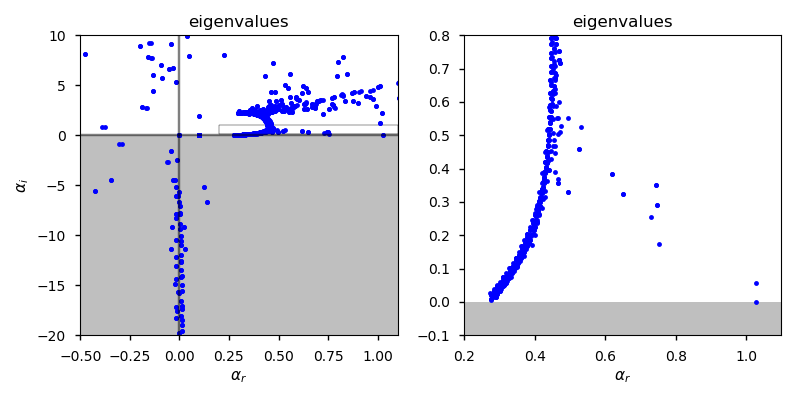

In [7]:
# run primitive formulation in spatial dimension $\alpha$ with spatial z
ny=101
nz=6
kwargs={
    'ny':ny,
    'nz':nz,
    'iBCs':True,
    'iplot':True,
    'omega':0.27,
    'Re':6000,
    'order':4,
    'large_multiple':1.e1,
}
eig_p1,evec_p1,eig_i_p1 = set_and_solve_eig_primitive_spatial_z(**kwargs)
#eig_p.tofile('eig_p.dat')
#evec_p.tofile('evec_p.dat')

#### output evec_p1 to binary

<IPython.core.display.Javascript object>


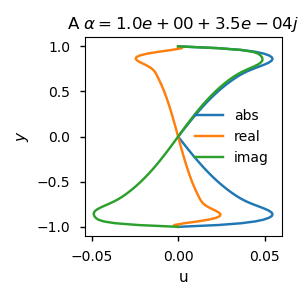

<IPython.core.display.Javascript object>


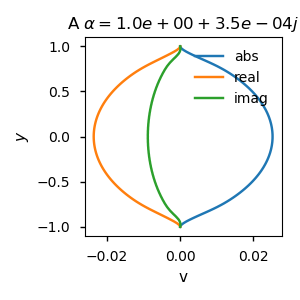

<IPython.core.display.Javascript object>


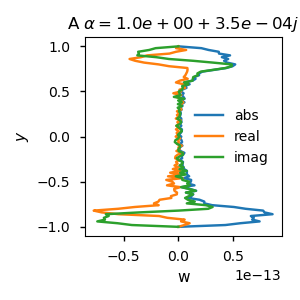

<IPython.core.display.Javascript object>


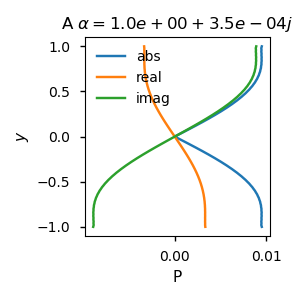

saved eig= (1.02727206986+0.000349066176285j)
saved evec= [ 0.00000000+0.j         -0.00229936-0.02299897j  0.00371270-0.03638899j
 ..., -0.00332402+0.00887504j -0.00332151+0.00885571j
 -0.00334118+0.00890656j]


In [18]:
Ai=1.0269-0.00068j
ny=101
nz=6
y=np.linspace(-1,1,ny)
z=np.linspace(0,1,nz)
i=5
plot_evec_a_branch(y,ny,Ai,eig_p1,evec_p1[(6*i+0)*ny:(6*i+1)*ny],title='u',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p1,evec_p1[(6*i+2)*ny:(6*i+3)*ny],title='v',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p1,evec_p1[(6*i+4)*ny:(6*i+5)*ny],title='w',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p1,evec_p1[(6*i+5)*ny:(6*i+6)*ny],title='P',eig_type=r'\alpha')
evec_to_save = np.concatenate(
    [evec_p1[(6*i+j)*ny:(6*i+j+1)*ny] for i in range(nz) for j in [0,2,4,5]],
    axis=0
)
save_evec_a_branch(y,z,Ai,eig_p1,evec_to_save,filename='uvwP_101')

inputs:
    ny=151 nz=6 order=4('omega', 0.27)('Re', 6000)('large_multiple', 10.0)
check max and min eig
    (-0.269630671854-6003.84485828j)
    (2.68086739844e-08-3.16914405687e-10j)
check isnan and isinf
    []
    [ inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j]
  bad boundary condition eigenfunctions satisfying u=0
    [ 0.72944058+0.j  0.72944058+0.j  0.72944058+0.j  0.72944058+0.j
  0.72944058+0.j  0.72944058+0.j] with associated eig-value of [ 0.1+0.j]  u(y=-1 )=0
    [ 0.72962375+0.j  0

<IPython.core.display.Javascript object>


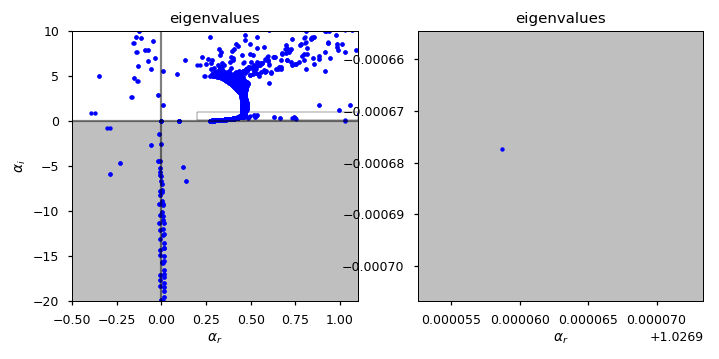

In [14]:
# run primitive formulation in spatial dimension $\alpha$ with spatial z
ny=151
nz=6
kwargs={
    'ny':ny,
    'nz':nz,
    'iBCs':True,
    'iplot':True,
    'omega':0.27,
    'Re':6000,
    'order':4,
    'large_multiple':1.e1,
}
eig_p2,evec_p2,eig_i_p2 = set_and_solve_eig_primitive_spatial_z(**kwargs)
#eig_p.tofile('eig_p.dat')
#evec_p.tofile('evec_p.dat')

inputs:
    ny=201 nz=6 order=4('omega', 0.27)('Re', 6000)('large_multiple', 10.0)
check max and min eig
    (-0.269284681739-6007.67689226j)
    (1.15435628189e-08-4.31892371668e-08j)
check isnan and isinf
    []
    [ inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j  inf+0.j
  inf+0.j  inf+0.j  inf+0.j  inf+0.j]
  bad boundary condition eigenfunctions satisfying u=0
    [ 0.65872533+0.j  0.65872533+0.j  0.65872533+0.j  0.65872533+0.j
  0.65872533+0.j  0.65872533+0.j] with associated eig-value of [ 0.1+0.j]  u(y=-1 )=0
    [ 0.65886746+0.j  0

<IPython.core.display.Javascript object>


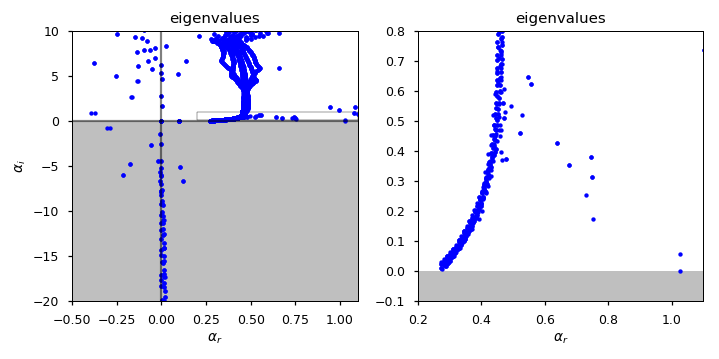

In [7]:
# run primitive formulation in spatial dimension $\alpha$ with spatial z
ny=201
nz=6
kwargs={
    'ny':ny,
    'nz':nz,
    'iBCs':True,
    'iplot':True,
    'omega':0.27,
    'Re':6000,
    'order':4,
    'large_multiple':1.e1,
}
eig_p3,evec_p3,eig_i_p3 = set_and_solve_eig_primitive_spatial_z(**kwargs)
#eig_p.tofile('eig_p.dat')
#evec_p.tofile('evec_p.dat')

#### Output eig_p3

In [16]:
%ls -gohF

total 1.6M
-rw-r--r-- 1  38K Apr  9 12:36 Checks_and_OldCode.ipynb
-rw-r--r-- 1 786K Apr 24 15:31 OrrSommerfeld_and_primitive.ipynb
-rw-r--r-- 1   16 Apr 24 13:06 u_eig.dat
-rw-r--r-- 1 3.2K Apr 24 13:06 u_evec.dat
-rw-r--r-- 1   16 Apr 24 15:31 uvwP_101_eig.dat
-rw-r--r-- 1 1.6K Apr 24 15:31 uvwP_101_evec.dat
-rw-r--r-- 1 1.6K Apr 24 15:31 uvwP_101_y.dat
-rw-r--r-- 1 1.6K Apr 24 13:06 u_y.dat


<IPython.core.display.Javascript object>


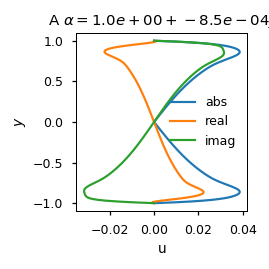

<IPython.core.display.Javascript object>


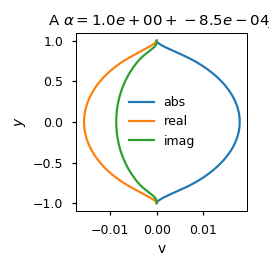

<IPython.core.display.Javascript object>


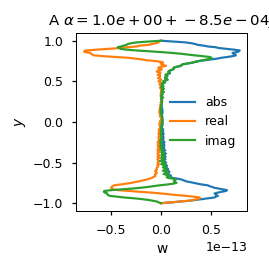

<IPython.core.display.Javascript object>


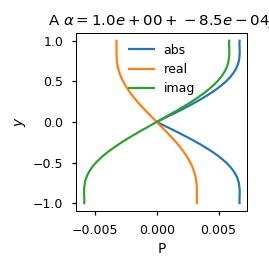

saved eig= (1.02686889136-0.000845412277229j)
saved evec= [ 0.00000000+0.j         -0.00078224-0.00919877j  0.00063002-0.0162882j
 ..., -0.00324606+0.00584984j -0.00324680+0.00584502j
 -0.00324992+0.00585872j]


In [9]:
Ai=1.0269-0.00068j
ny=201
nz=6
y=np.linspace(-1,1,ny)
z=np.linspace(0,1,nz)
plot_evec_a_branch(y,ny,Ai,eig_p3,evec_p3[:ny],title='u',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p3,evec_p3[2*ny:3*ny],title='v',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p3,evec_p3[4*ny:5*ny],title='w',eig_type=r'\alpha')
plot_evec_a_branch(y,ny,Ai,eig_p3,evec_p3[5*ny:6*ny],title='P',eig_type=r'\alpha')
evec_to_save = np.concatenate(
    [evec_p3[(6*i+j)*ny:(6*i+j+1)*ny] for i in range(nz) for j in [0,2,4,5]],
    axis=0
)
save_evec_a_branch(y,z,Ai,eig_p3,evec_to_save,filename='uvwP_201')

In [ ]:
# mesh convergence for primitive formulation in spatial $\alpha$ with spatial z
c=np.array([
    0.61167+0.140491j
])

n_all = [(47,8),(51,8),(61,8),(71,8),(81,8)]
#n_all = [(47,6),(51,6),]
orders=[2,4,6,]
#orders=[2,4,]

kwargs={
    'iBCs':False,
    'iplot':False,
    'omega':0.3,
    'Re':2000,
    'large_multiple':1.e1,
    'input_line':False,
}
plot_mesh_convergence(set_and_solve_eig_primitive_spatial_z,c,n_all=n_all,orders=orders,z=True,**kwargs)

In [2]:
import numpy as np
z=np.linspace(0,1,6) + 0j
z.tofile('uvwP_201_z.dat')